# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [4]:
# Import warnings

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import random
# from google.colab import drive
%matplotlib inline

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [11]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)


numpy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file

df = pd.read_parquet('file.parquet')

FileNotFoundError: [Errno 2] No such file or directory: 'file.parquet'

How many rows are there?   -> 3041714
Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?  -> No

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [51]:
# from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
os.getcwd()

'/content/drive/My Drive/Assignments/EDA/data_NYC_Taxi/taxi_zones'

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
# read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/My Drive/Assignments/EDA/data_NYC_Taxi/trip_records')

# # Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
month_df = pd.DataFrame()
sampled_data = pd.DataFrame()
final3_df = pd.DataFrame()

# # iterate through the list of files and sample one by one:
for file_name in file_list:
     print(file_name)
     try:
         # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)
        #print(file_path)
        # Reading the current file

        month_df = pd.read_parquet(file_path)
        #print('reading done')
        month_df['date'] = month_df['tpep_pickup_datetime'].dt.date
        month_df['hour'] = month_df['tpep_pickup_datetime'].dt.hour
        print('date n column are separated')
        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        grouped = month_df.groupby(['date', 'hour'])
        # print(grouped)
        # for date in month_df['date'] :
        #     for hour in month_df['hour'] :
        for group in grouped :
            # Iterate through each hour of the selected date
                #sample = hour_data.sample(frac = 0.05, random_state = 42)
                # Sample 5% of the hourly data randomly
            sampled_data = grouped.apply(lambda x: x.sample(frac=0.05, random_state=42), include_groups=False)
                # add data of this hour to the dataframe

        # Concatenate the sampled data of all the dates to a single dataframe
        final3_df = pd.concat([final3_df,sampled_data])# we initialised this empty DF earlier

     except Exception as e:
        print(f"Error reading file {file_name}: {e}")


2023-9.parquet
date n column are separated
2023-5.parquet
date n column are separated
2023-6.parquet
date n column are separated
2023-2.parquet
date n column are separated
2023-1.parquet
date n column are separated
2023-8.parquet
date n column are separated
2023-7.parquet
date n column are separated
2023-10.parquet
date n column are separated
2023-3.parquet
date n column are separated
2023-12.parquet
date n column are separated
2023-4.parquet
date n column are separated
2023-11.parquet
date n column are separated


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [13]:
# Store the df in csv/parquet
final3_df = pd.read_parquet(r"C:\Users\Anuja\Desktop\Data_Study_Upgrad\EDA\EDA_Assignment\Result_Files\final3_df.parquet")
# final3_df.to_csv('final3_df_csv.csv')

In [15]:
final3_df.shape[0]

1896400

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [17]:
index = df.index
print(index)

NameError: name 'df' is not defined

In [23]:
df = final3_df
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1896400 entries, (datetime.date(2023, 8, 31), 23, 119) to (datetime.date(2023, 11, 30), 23, 3203330)
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [25]:
# Fix the index and drop any columns that are not needed
df = final3_df
df1  = df.reset_index(drop = True)
#df1.head(29)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [27]:
# Combine the two airport fee columns
df1['Airport_Fee1'] = df1['Airport_fee'].combine_first(df1['airport_fee'])

In [29]:
df1['Airport_Fee1'].isna().value_counts()

Airport_Fee1
False    1831526
True       64874
Name: count, dtype: int64

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [31]:
# check where values of fare amount are negative

df1.loc[df1['fare_amount'] < 0].value_counts()

Series([], Name: count, dtype: int64)

Did you notice something different in the `RatecodeID` column for above records?

In [33]:
# Analyse RatecodeID for the negative fare amounts
df1.loc[df1['RatecodeID'] < 0].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
# Find which columns have negative values

## cOLUMNS WITH -vE VALUES :
# 1. extra
# 2. mta_tax
# 3. improvement_surcharge
# 4. total_amount
# 5. congestion_surcharge
# 6. Airport_Fee1

In [35]:
fare_neg = df1['fare_amount'] < 0
print(fare_neg.value_counts())

fare_amount
False    1896400
Name: count, dtype: int64


In [40]:
extra_neg = df1['extra'] < 0
print(extra_neg.value_counts())

extra
False    1896397
True           3
Name: count, dtype: int64


In [37]:
mta_tax_neg = df1['mta_tax'] < 0
print(mta_tax_neg.value_counts())

mta_tax
False    1896327
True          73
Name: count, dtype: int64


In [39]:
tip_amount_neg = df1['tip_amount'] < 0
print(tip_amount_neg.value_counts())

tip_amount
False    1896400
Name: count, dtype: int64


In [41]:
tolls_amount_neg = df1['tolls_amount'] < 0
print(tolls_amount_neg.value_counts())

tolls_amount
False    1896400
Name: count, dtype: int64


In [43]:
impr_surcharge_neg = df1['improvement_surcharge'] < 0
print(impr_surcharge_neg.value_counts())

improvement_surcharge
False    1896322
True          78
Name: count, dtype: int64


In [45]:
total_amount_neg = df1['total_amount'] < 0
print(total_amount_neg.value_counts())

total_amount
False    1896322
True          78
Name: count, dtype: int64


In [47]:
congestion_surcharge_neg = df1['congestion_surcharge'] < 0
print(congestion_surcharge_neg.value_counts())

congestion_surcharge
False    1896344
True          56
Name: count, dtype: int64


In [49]:
Airport_Fee1_neg = df1['Airport_Fee1'] < 0
print(Airport_Fee1_neg.value_counts())

Airport_Fee1
False    1896385
True          15
Name: count, dtype: int64


In [ ]:
# fix these negative values
### by flipping -ve to +ve

In [51]:
df1['extra1'] = df1['extra'].abs()

count = df1['extra1'] <0
count.value_counts()

extra1
False    1896400
Name: count, dtype: int64

In [53]:
df1['mta_tax1'] = df1['mta_tax'].abs()

count = df1['mta_tax1'] < 0
count.value_counts()

mta_tax1
False    1896400
Name: count, dtype: int64

In [55]:
df1['improvement_surcharge1'] = df1['improvement_surcharge'].abs()

count = df1['improvement_surcharge1'] < 0
count.value_counts()

improvement_surcharge1
False    1896400
Name: count, dtype: int64

In [57]:
df1['congestion_surcharge1'] = df1['congestion_surcharge'].abs()

count = df1['congestion_surcharge1'] < 0
count.value_counts()

congestion_surcharge1
False    1896400
Name: count, dtype: int64

In [59]:
df1['Airport_Fee2'] = df1['Airport_Fee1'].abs()

count = df1['Airport_Fee2'] < 0
count.value_counts()

Airport_Fee2
False    1896400
Name: count, dtype: int64

In [61]:
df1['total_amount1'] = df1['total_amount'].abs()

count = df1['total_amount1'] < 0
count.value_counts()

total_amount1
False    1896400
Name: count, dtype: int64

In [63]:
###### Take BackUP of df1 ##############

df1_copy = df1.copy(deep=True)
df1_copy.to_parquet('df1_copy_Fixing_column.parquet')

In [65]:
#df1 = pd.read_parquet('df1_copy_Fixing_column.parquet')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   VendorID                int64         
 1   tpep_pickup_datetime    datetime64[us]
 2   tpep_dropoff_datetime   datetime64[us]
 3   passenger_count         float64       
 4   trip_distance           float64       
 5   RatecodeID              float64       
 6   store_and_fwd_flag      object        
 7   PULocationID            int64         
 8   DOLocationID            int64         
 9   payment_type            int64         
 10  fare_amount             float64       
 11  extra                   float64       
 12  mta_tax                 float64       
 13  tip_amount              float64       
 14  tolls_amount            float64       
 15  improvement_surcharge   float64       
 16  total_amount            float64       
 17  congestion_surcharge    float64       
 18  Ai

In [67]:
## As I have created new columns for +ve values so dropping old columns and rename to old

df1.drop(columns=['airport_fee','Airport_Fee1','Airport_fee','extra','mta_tax','improvement_surcharge','congestion_surcharge','total_amount'], inplace = True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   VendorID                int64         
 1   tpep_pickup_datetime    datetime64[us]
 2   tpep_dropoff_datetime   datetime64[us]
 3   passenger_count         float64       
 4   trip_distance           float64       
 5   RatecodeID              float64       
 6   store_and_fwd_flag      object        
 7   PULocationID            int64         
 8   DOLocationID            int64         
 9   payment_type            int64         
 10  fare_amount             float64       
 11  tip_amount              float64       
 12  tolls_amount            float64       
 13  extra1                  float64       
 14  mta_tax1                float64       
 15  improvement_surcharge1  float64       
 16  congestion_surcharge1   float64       
 17  Airport_Fee2            float64       
 18  to

In [69]:
df1.rename(columns={'Airport_Fee2' : 'Airport_Fee','extra1' : 'extra','mta_tax1' : 'mta_tax' ,'improvement_surcharge1' : 'improvement_surcharge',
                    'congestion_surcharge1' : 'congestion_surcharge','total_amount1':'total_amount'}, inplace = True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  improvement_surcharge  float64       
 16  congestion_surcharge   float64       
 17  Airport_Fee            float64       
 18  total_amount          

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [71]:
# Find the proportion of missing values in each column

df1.isnull().sum()/ len(df1)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.034209
trip_distance            0.000000
RatecodeID               0.034209
store_and_fwd_flag       0.034209
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
tip_amount               0.000000
tolls_amount             0.000000
extra                    0.000000
mta_tax                  0.000000
improvement_surcharge    0.000000
congestion_surcharge     0.034209
Airport_Fee              0.034209
total_amount             0.000000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [73]:
## Display the rows with null values :

df1['passenger_count'].isnull().sum()

64874

In [75]:
## Display th Rows with 0 values :
zero_pass = df1[df1['passenger_count'] == 0 ]
zero_pass.head(3)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
188         1  2023-09-01 01:27:10   2023-09-01 01:40:32              0.0   
325         1  2023-09-01 05:49:22   2023-09-01 06:04:20              0.0   
379         1  2023-09-01 06:28:39   2023-09-01 07:07:18              0.0   

     trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
188            3.1         1.0                  N           231           234   
325            6.7         1.0                  N           132            76   
379           17.6         2.0                  N           132           186   

     payment_type  fare_amount  tip_amount  tolls_amount  extra  mta_tax  \
188             1         15.6        1.00          0.00   3.50      0.5   
325             2         27.5        0.00          0.00   2.75      0.5   
379             1         70.0       20.65          6.94   4.25      0.5   

     improvement_surcharge  congestion_surcharge  Airport_Fee  total_amount  
188                    1.0                   2.5         0.00         21.60  
325                    1.0                   0.0         1.75         31.75  
379                    1.0                   2.5         1.75        103.34

In [77]:
# Impute NaN values in 'passenger_count'
## NaN % for passenger count is  = 0.034209 and zero count.
## I am filling Null and 0s wwith mode as most passangers prerer the  Taxi is NY is 1
## Also as Mean, Median and Mode is all the same for Passanger_count

mode = df1['passenger_count'].mode()[0]
#print(mode)

df1['passenger_count'] = df1['passenger_count'].fillna(mode)

Did you find zeroes in passenger_count? Handle these.

In [79]:
count = df1['passenger_count'].isnull()
count.value_counts()
# df1.info()

passenger_count
False    1896400
Name: count, dtype: int64

In [85]:
## I am replacing Passenger count = 0 as well with mode as the other details 
### like Pick , Drop time,total amount are mentioned so these are not Void Trips

count = df1['passenger_count'] == 0
count.value_counts()

# mode = df1['passenger_count'].mode()[0]
# # print(mode)
# df1['passenger_count'] = df1['passenger_count'].replace(0, mode)


passenger_count
False    1896400
Name: count, dtype: int64

In [ ]:
# plt.pie(df1['passenger_count'], labels=df1['passenger_count'], autopct='%1.1f%%', startangle=140)

# plt.axis('equal')  # Equal aspect ratio makes the pie a circle
# plt.show()

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [91]:
# Fix missing values in 'RatecodeID'

count  = df1['RatecodeID'].isnull()
count.value_counts()

# mode = df1['RatecodeID'].mode()[0]
# df1['RatecodeID'] = df1['RatecodeID'].fillna(mode)
# df1.info()

RatecodeID
False    1896400
Name: count, dtype: int64

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [99]:
# handle null values in congestion_surcharge : Impute 0 in place of Nan in congestion_surcharge as any other value may impact the total fare amount

# count  = df1['congestion_surcharge']
# count.value_counts()

count  = df1['congestion_surcharge'].isnull()
count.value_counts()


# df1['congestion_surcharge'] = df1['congestion_surcharge'].fillna(0)
# df1.info()


congestion_surcharge
False    1896400
Name: count, dtype: int64

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [101]:
# Handle any remaining missing values

count = df1.isnull().sum()
count

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID                   0
store_and_fwd_flag       64874
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
tip_amount                   0
tolls_amount                 0
extra                        0
mta_tax                      0
improvement_surcharge        0
congestion_surcharge         0
Airport_Fee              64874
total_amount                 0
dtype: int64

In [105]:
## Handle missing value in store_and_fwd_flag

# count  = df1['store_and_fwd_flag']
# count.value_counts()


count  = df1['store_and_fwd_flag'].isnull()
count.value_counts()

# mode = df1['store_and_fwd_flag'].mode()[0]
# df1['store_and_fwd_flag'] = df1['store_and_fwd_flag'].fillna(mode)

store_and_fwd_flag
False    1896400
Name: count, dtype: int64

In [111]:
## Handle missing value in Airport_Fee : Imputing it with 0s becasue total fare is already calculated.
count  = df1['Airport_Fee'].isnull()
count.value_counts()

# df1['Airport_Fee'] = df1['Airport_Fee'].fillna(0)


Airport_Fee
False    1896400
Name: count, dtype: int64

In [113]:
count  = df1['payment_type']
count.value_counts()

payment_type
1    1492374
2     316452
0      64874
4      13685
3       9015
Name: count, dtype: int64

In [115]:
### Write the df1 dataframe into file as a backup
df1.to_parquet('df1_Miss_val_SnFFlag1.parquet')


In [119]:
## count
count  = df1['payment_type']
count.value_counts()

payment_type
1    1492374
2     316452
0      64874
4      13685
3       9015
Name: count, dtype: int64

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [ ]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [123]:
# remove passenger_count > 6

# count = df1['passenger_count'] > 6
# count.value_counts()


df2 = df1[df1['passenger_count'] <= 6]
df2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1896379 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  improvement_surcharge  float64       
 16  congestion_surcharge   float64       
 17  Airport_Fee            float64       
 18  total_amount           floa

In [125]:
count = df2['payment_type']
count.value_counts()
#df2.head()

payment_type
1    1492356
2     316449
0      64874
4      13685
3       9015
Name: count, dtype: int64

In [127]:
# Continue with outlier handling

### 1. Check Outlier in Payment Type
Q1 = df2['payment_type'].quantile(0.25)
#print("Q1 = " ,Q1)
Q3 = df2['payment_type'].quantile(0.75)
#print("Q3 = " ,Q3)
IQR = Q3 - Q1
print("IQR = " ,IQR)
# Determine outliers
lower_bound = Q1 - 1.5 * IQR
print("lower_bound: ", lower_bound)
upper_bound = Q3 + 1.5 * IQR
print("upper_bound:", upper_bound)
# outliers = df2[(df2['payment_type'] < lower_bound) | (df2['payment_type'] > upper_bound)]
# count = outliers.value_counts()
# print(count)


IQR =  0.0
lower_bound:  1.0
upper_bound: 1.0


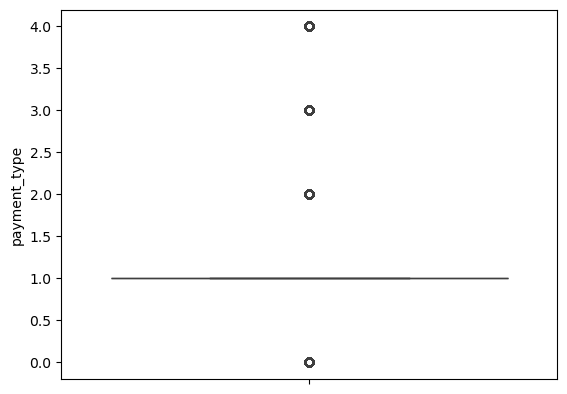

In [129]:
sns.boxplot(df2['payment_type'])
plt.show()

In [167]:
################ To Remove outlier like 0 

df3 = df2[(df2['payment_type'] != 0 )]
grp = df3.groupby('payment_type')['payment_type'].count()
grp

payment_type
1    1492356
2     316449
3       9015
4      13685
Name: payment_type, dtype: int64

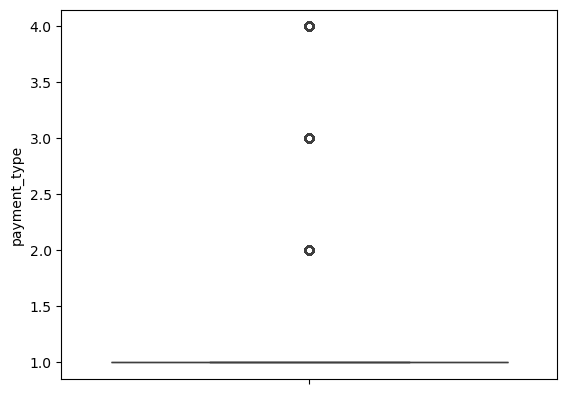

In [159]:
sns.boxplot(df3['payment_type'])
plt.show()

In [161]:
## Write the df3 file
df3.to_parquet('df3_Outlier_Handling.parquet')

In [169]:
### 2. Check Outlier in trip distance

Q1 = df3['trip_distance'].quantile(0.25)
print("Q1 = " ,Q1)
Q3 = df3['trip_distance'].quantile(0.75)
print("Q3 = " ,Q3)
IQR = Q3 - Q1
print("IQR = " ,IQR)
lower_bound = Q1 - 1.5 * IQR
print("lower_bound: ", lower_bound)
upper_bound = Q3 + 1.5 * IQR
print("upper_bound:", upper_bound)
# outliers = df3[(df3['trip_distance'] < lower_bound) | (df3['trip_distance'] > upper_bound)]
# count = outliers.value_counts()
# print(count)

Q1 =  1.05
Q3 =  3.37
IQR =  2.3200000000000003
lower_bound:  -2.4300000000000006
upper_bound: 6.8500000000000005


In [177]:
count = df3[df3['trip_distance'] < 1 & (df3['fare_amount'] > 300)]
count

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
8018            2  2023-09-02 22:01:05   2023-09-02 22:01:20              1.0   
16824           1  2023-09-05 10:16:13   2023-09-05 10:20:56              1.0   
182061          1  2023-02-09 07:37:30   2023-02-09 07:39:13              1.0   
311202          2  2023-04-05 21:16:43   2023-04-05 21:25:57              1.0   
446020          2  2023-04-30 14:21:36   2023-04-30 14:22:11              4.0   
551004          2  2023-03-19 14:58:50   2023-03-19 14:59:46              4.0   
614222          1  2023-03-31 16:56:04   2023-03-31 16:57:02              1.0   
655024          1  2023-01-09 16:17:32   2023-01-09 16:20:41              1.0   
663423          1  2023-01-11 12:38:54   2023-01-11 12:38:54              1.0   
707206          2  2023-01-19 20:58:47   2023-01-19 20:58:51              4.0   
832345          2  2023-07-15 16:08:15   2023-07-15 16:08:35              2.0   
862734          1  2023-07-21 17:12:41   2023-07-21 17:14:50              1.0   
893019          2  2023-07-27 19:30:15   2023-07-27 19:30:50              1.0   
995600          1  2023-05-15 13:28:42   2023-05-15 13:29:45              1.0   
1023654         2  2023-05-19 21:04:06   2023-05-19 21:04:22              2.0   
1039827         2  2023-05-22 19:38:15   2023-05-22 19:38:38              1.0   
1046790         2  2023-05-24 02:11:35   2023-05-24 02:11:57              1.0   
1134518         2  2023-10-09 21:36:01   2023-10-09 21:39:15              1.0   
1156522         1  2023-10-13 18:22:04   2023-10-13 18:22:38              1.0   
1192961         2  2023-10-20 01:11:27   2023-10-20 01:13:03              1.0   
1301442         1  2023-06-08 04:59:03   2023-06-08 04:59:38              2.0   
1313351         2  2023-06-10 01:58:47   2023-06-10 01:59:16              1.0   
1314222         1  2023-06-10 10:40:51   2023-06-10 10:41:38              1.0   
1350327         2  2023-06-16 17:16:53   2023-06-16 17:17:05              4.0   
1368988         2  2023-06-20 15:38:20   2023-06-20 15:38:30              1.0   
1373469         2  2023-06-21 12:05:21   2023-06-21 12:05:42              1.0   
1393465         1  2023-06-24 19:41:42   2023-06-24 19:43:18              1.0   
1419098         2  2023-06-29 20:56:07   2023-06-29 20:56:15              1.0   
1466409         2  2023-12-07 23:39:43   2023-12-07 23:39:59              1.0   
1563921         2  2023-12-24 14:01:07   2023-12-24 14:01:44              1.0   
1592833         1  2023-08-01 11:12:09   2023-08-01 11:12:09              1.0   
1596140         2  2023-08-01 22:06:03   2023-08-01 22:06:41              2.0   
1650742         2  2023-08-13 18:44:08   2023-08-13 18:44:22              4.0   
1682940         2  2023-08-20 21:39:04   2023-08-20 21:39:12              2.0   
1682949         2  2023-08-20 21:56:48   2023-08-20 21:56:59              2.0   
1703337         2  2023-08-25 16:13:28   2023-08-25 16:13:42              2.0   
1712699         2  2023-08-27 18:46:43   2023-08-27 18:47:01              1.0   
1872090         2  2023-11-26 16:04:06   2023-11-26 16:04:12              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
8018              0.00         5.0                  N           226   
16824             0.70         1.0                  N           249   
182061            0.00         5.0                  N           246   
311202            0.00         5.0                  N           265   
446020            0.08         5.0                  N           130   
551004            0.21         5.0                  N           164   
614222            0.00         5.0                  N           181   
655024            0.00         5.0                  N           141   
663423            0.00        99.0                  N           264   
707206            0.00         5.0                  N           265   
832345            0.00         5.0                  N           265 

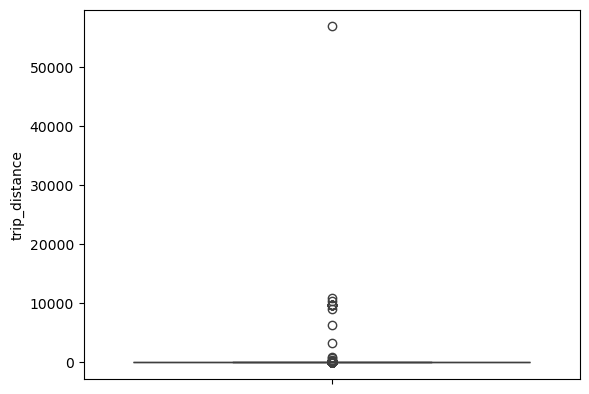

In [173]:
sns.boxplot(df3['trip_distance'])
plt.show()

In [190]:
## Remove the trips where trip distance is < 1 and fare is > 300 
df4_1 = df3[~(df3['trip_distance'] < 1 & (df3['fare_amount'] > 300))]


In [204]:
## Remove the trips where trip distance is > 250 miles
#count  = df4_1[df4_1['trip_distance'] > 250]
#df4_2 = df4_1[~(df4_1['trip_distance'] > 250)]
df4_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1831448 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  improvement_surcharge  float64       
 16  congestion_surcharge   float64       
 17  Airport_Fee            float64       
 18  total_amount           floa

In [212]:
## Remove Entries where trip_distance and fare_amount are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)

#count = df4_2[(df4_2['trip_distance'] == 0) &(df4_2['fare_amount'] == 0) & (df4_2['PULocationID'] != df4_2['DOLocationID']) ]
#df4_3 = df4_2[~((df4_2['trip_distance'] == 0) &(df4_2['fare_amount'] == 0) & (df4_2['PULocationID'] != df4_2['DOLocationID']) )]
df4_3.size 

34796372

In [220]:
##Handle Trip distance Outliers
df5 = df4_3
df5['trip_distance'] = np.where(df5['trip_distance'] < lower_bound, lower_bound, df5['trip_distance'])  ## Flooring
df5['trip_distance'] = np.where(df5['trip_distance'] > upper_bound, upper_bound, df5['trip_distance'])  ## Capping/Ceiling


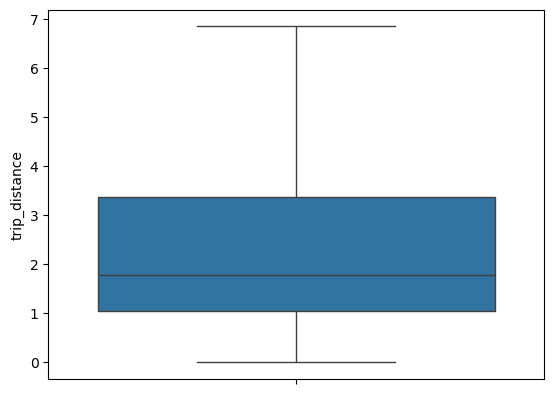

In [222]:
sns.boxplot(df5['trip_distance'])
plt.show()

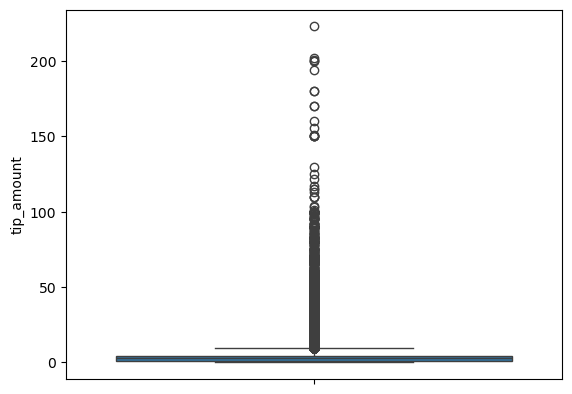

In [224]:
### 3. Check Outlier in tip amount
sns.boxplot(df5['tip_amount'])
plt.show()

In [228]:
Q1 = df5['tip_amount'].quantile(0.25)
print("Q1 = " ,Q1)
Q3 = df5['tip_amount'].quantile(0.75)
print("Q3 = " ,Q3)
IQR = Q3 - Q1
print("IQR = " ,IQR)
lower_bound1 = Q1 - 1.5 * IQR
print("lower_bound: ", lower_bound1)
upper_bound1 = Q3 + 1.5 * IQR
print("upper_bound:", upper_bound1)
# outliers = df4[(df4['tip_amount'] < lower_bound) | (df4['tip_amount'] > upper_bound)]
# count = outliers.value_counts()
# print(count)

Q1 =  1.0
Q3 =  4.45
IQR =  3.45
lower_bound:  -4.175000000000001
upper_bound: 9.625


In [ ]:
count = df5['tip_amount']
count.value_counts().sort_index()

tip_amount
0.00      373610
0.01        1291
0.02         412
0.03         184
0.04         102
0.05         254
0.06          27
0.07          27
0.08         278
0.09          60
0.10         565
0.11          68
0.12          30
0.13          22
0.14          17
0.15         144
0.16           8
0.17          20
0.18          44
0.19          15
0.20         258
0.21          27
0.22          42
0.23          17
0.24          19
0.25          69
0.26          18
0.27           9
0.28          17
0.29          21
0.30          93
0.31           9
0.32          11
0.33          27
0.34          17
0.35          18
0.36          17
0.37           9
0.38          16
0.39          11
0.40         107
0.41          15
0.42          20
0.43          11
0.44          23
0.45          19
0.46          37
0.47          19
0.48          15
0.49          60
0.50        1132
0.51          11
0.52          60
0.53          23
0.54          59
0.55          46
0.56          77
0.57          18
0.58          60
0.59          23
0.60         194
0.61          58
0.62          26
0.63          95
0.64          57
0.65          45
0.66          64
0.67          10
0.68          77
0.69          35
0.70         270
0.71          15
0.72         102
0.73          37
0.74          89
0.75         274
0.76          46
0.77          95
0.78          74
0.79          59
0.80         364
0.81          32
0.82          88
0.83          29
0.84         208
0.85          43
0.86          90
0.87          53
0.88         164
0.89          49
0.90         377
0.91         366
0.92          50
0.93          57
0.94         132
0.95          45
0.96          72
0.97          18
0.98         570
0.99          49
1.00       73418
1.01         227
1.02          63
1.03          73
1.04          63
1.05         698
1.06          54
1.07          30
1.08         589
1.09         103
1.10        1007
1.11         595
1.12         768
1.13          25
1.14          69
1.15         394
1.16         206
1.17          37
1.18         196
1.19         813
1.20        1900
1.21          61
1.22         446
1.23         274
1.24          53
1.25        1419
1.26        1125
1.27          43
1.28          65
1.29         474
1.30        1299
1.31          46
1.32         205
1.33         891
1.34         119
1.35          82
1.36         839
1.37         473
1.38         101
1.39          36
1.40        2067
1.41         121
1.42          65
1.43         532
1.44         371
1.45         127
1.46         358
1.47        1679
1.48          47
1.49          36
1.50       18697
1.51         505
1.52         326
1.53          37
1.54        1274
1.55         146
1.56          83
1.57         568
1.58        1574
1.59         137
1.60        1555
1.61         702
1.62         465
1.63          83
1.64         662
1.65        1039
1.66         159
1.67          52
1.68        4143
1.69          58
1.70        1156
1.71         407
1.72         997
1.73          75
1.74         869
1.75        1552
1.76         215
1.77          53
1.78        1533
1.79         728
1.80        3211
1.81          56
1.82        5622
1.83         668
1.84         324
1.85         941
1.86         377
1.87          19
1.88        1762
1.89        2079
1.90         810
1.91          47
1.92         378
1.93         478
1.94         887
1.95        2674
1.96        8509
1.97          49
1.98         108
1.99         387
2.00       91893
2.01          45
2.02        3560
2.03         465
2.04         933
2.05         273
2.06         729
2.07         382
2.08         461
2.09          58
2.10       17739
2.11          39
2.12          33
2.13         262
2.14        1027
2.15        1976
2.16        5583
2.17         414
2.18         995
2.19         122
2.20        6004
2.21         312
2.22         572
2.23          56
2.24       12817
2.25        2543
2.26         663
2.27         971
2.28         583
2.29          30
2.30        9885
2.31        1681
2.32        2000
2.33          43
2.34       

In [230]:
### Clear the Outliers as for further analysis we need relation between tip amount and other parameters
### These outliers wil impact the further analysis

df6 = df5
df6['tip_amount'] = np.where(df6['tip_amount'] < lower_bound, lower_bound, df6['tip_amount'])  ## Flooring
df6['tip_amount'] = np.where(df6['tip_amount'] > upper_bound, upper_bound, df6['tip_amount'])  ## Capping/Ceiling

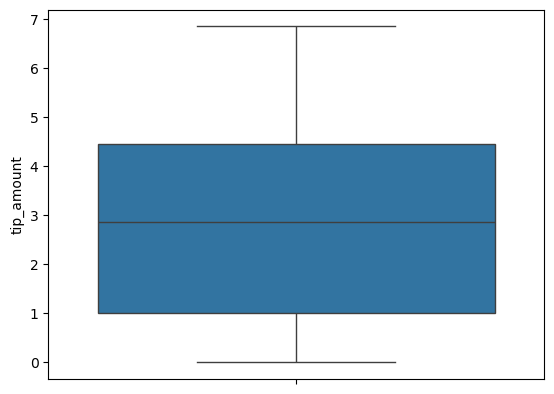

In [232]:
sns.boxplot(df6['tip_amount'])
plt.show()

In [234]:
### Write the File
df6.to_parquet('df6_Outlier_Handling.parquet')


# #df5_1 = pd.read_parquet('df5_1_Outlier_Handling.parquet')
# df5_1.info()


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [236]:
df6.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'extra',
 'mta_tax',
 'improvement_surcharge',
 'congestion_surcharge',
 'Airport_Fee',
 'total_amount']

In [238]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1831388 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  improvement_surcharge  float64       
 16  congestion_surcharge   float64       
 17  Airport_Fee            float64       
 18  total_amount           floa

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [240]:
df6.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   
2         2  2023-09-01 00:24:50   2023-09-01 00:27:19              2.0   
3         2  2023-09-01 00:19:27   2023-09-01 01:04:02              2.0   
4         2  2023-09-01 00:42:13   2023-09-01 01:20:20              2.0   
5         2  2023-09-01 00:11:38   2023-09-01 00:17:56              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.11         1.0                  N           114           246   
2           0.56         1.0                  N           142           142   
3           6.85         2.0                  N           132           163   
4           6.85         1.0                  N           249           180   
5           0.71         1.0                  N           144           232   

   payment_type  fare_amount  tip_amount  tolls_amount  extra  mta_tax  \
0             1         21.2        0.00          0.00    1.0      0.5   
2             2          5.1        0.00          0.00    1.0      0.5   
3             1         70.0        6.85          6.94    0.0      0.5   
4             4         59.7        0.00          0.00    1.0      0.5   
5             1          7.9        2.00          0.00    1.0      0.5   

   improvement_surcharge  congestion_surcharge  Airport_Fee  total_amount  
0                    1.0                   2.5         0.00          26.2  
2                    1.0                   2.5         0.00          10.1  
3                    1.0                   2.5         1.75          98.4  
4                    1.0                   2.5         0.00          64.7  
5                    1.0                   2.5         0.00          14.9

In [242]:
### Create Columnsas Pickup Hours / Pickup Days / Pickup months
df6['Pickup_hour'] = df6['tpep_pickup_datetime'].dt.hour
df6['Pickup_days'] = df6['tpep_pickup_datetime'].dt.weekday
df6['Pickup_month'] = df6['tpep_pickup_datetime'].dt.month
df6.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   
2         2  2023-09-01 00:24:50   2023-09-01 00:27:19              2.0   
3         2  2023-09-01 00:19:27   2023-09-01 01:04:02              2.0   
4         2  2023-09-01 00:42:13   2023-09-01 01:20:20              2.0   
5         2  2023-09-01 00:11:38   2023-09-01 00:17:56              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.11         1.0                  N           114           246   
2           0.56         1.0                  N           142           142   
3           6.85         2.0                  N           132           163   
4           6.85         1.0                  N           249           180   
5           0.71         1.0                  N           144           232   

   payment_type  fare_amount  tip_amount  tolls_amount  extra  mta_tax  \
0             1         21.2        0.00          0.00    1.0      0.5   
2             2          5.1        0.00          0.00    1.0      0.5   
3             1         70.0        6.85          6.94    0.0      0.5   
4             4         59.7        0.00          0.00    1.0      0.5   
5             1          7.9        2.00          0.00    1.0      0.5   

   improvement_surcharge  congestion_surcharge  Airport_Fee  total_amount  \
0                    1.0                   2.5         0.00          26.2   
2                    1.0                   2.5         0.00          10.1   
3                    1.0                   2.5         1.75          98.4   
4                    1.0                   2.5         0.00          64.7   
5                    1.0                   2.5         0.00          14.9   

   Pickup_hour  Pickup_days  Pickup_month  
0           23            3             8  
2            0            4             9  
3            0            4             9  
4            0            4             9  
5            0            4             9

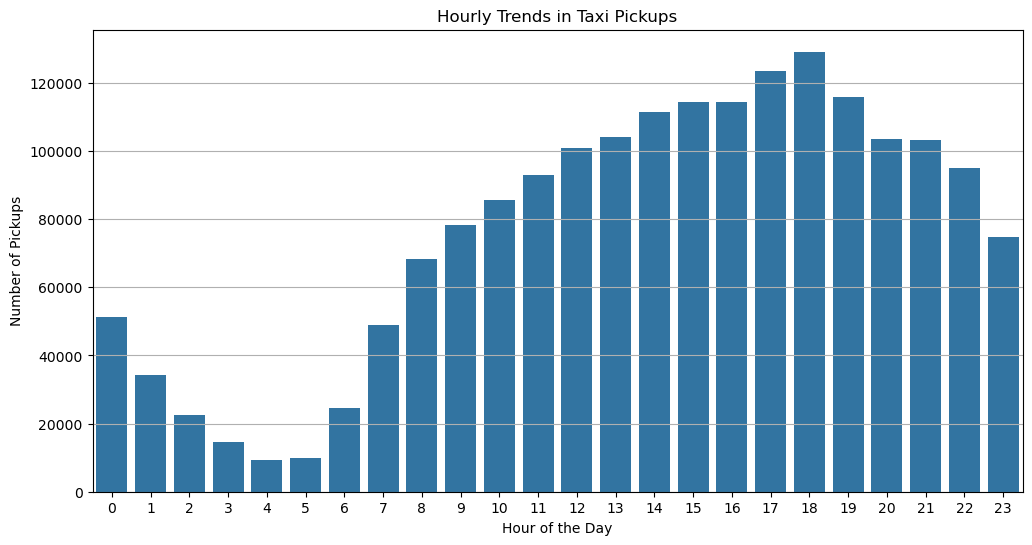

In [244]:
# Find and show the hourly trends in taxi pickups

grouped = df6.groupby('Pickup_hour')['Pickup_hour'].count()
#grouped
df_grp = grouped.reset_index(name = 'pickup_counts')
#df_grp
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grp, x='Pickup_hour', y = 'pickup_counts')
plt.title('Hourly Trends in Taxi Pickups')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(24))  # Show all hours on the x-axis
plt.grid(axis='y')
plt.show()

In [ ]:
count = df5_1['Pickup_hour'].value_counts()
count.sort_index()

NameError: name 'df5' is not defined

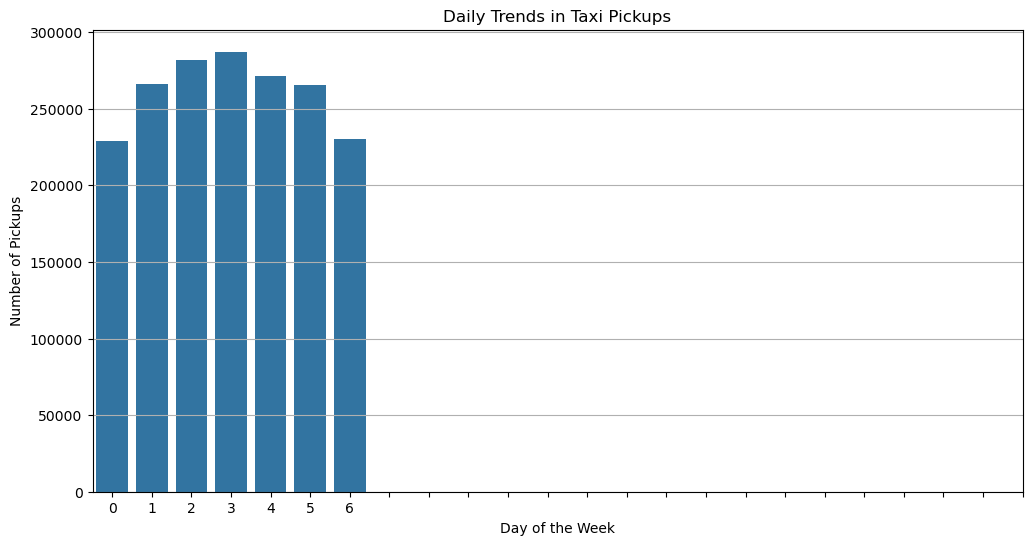

In [246]:
# Find and show the daily trends in taxi pickups (days of the week)

grouped = df6.groupby('Pickup_days')['Pickup_days'].count()
#grouped
df_grp = grouped.reset_index(name = 'pickup_counts')
#df_grp
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grp, x='Pickup_days', y = 'pickup_counts')
plt.title('Daily Trends in Taxi Pickups')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.xticks(range(24))  # Show all hours on the x-axis
plt.grid(axis='y')
plt.show()

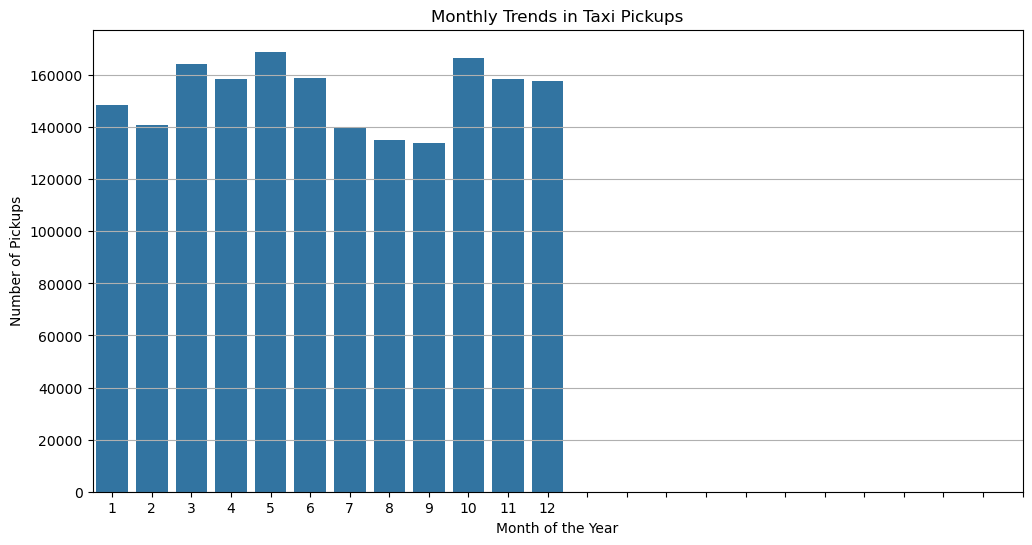

In [248]:
# Show the monthly trends in pickups

grouped = df6.groupby('Pickup_month')['Pickup_month'].count()
#grouped
df_grp = grouped.reset_index(name = 'pickup_counts')
#df_grp
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grp, x='Pickup_month', y = 'pickup_counts')
plt.title('Monthly Trends in Taxi Pickups')
plt.xlabel('Month of the Year')
plt.ylabel('Number of Pickups')
plt.xticks(range(24))  # Show all hours on the x-axis
plt.grid(axis='y')
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [ ]:
# Analyse the above parameters

count = df6['fare_amount'] == 0
count.sum()

# count1 = df6['tip_amount'] == 0
# count1.sum()

# count = df6['total_amount'] == 0
# count.sum()

# count = df6['trip_distance'] == 0
# count.sum()

np.int64(651)

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [250]:
# Create a df with non zero entries for the selected parameters.

df7 = df6[(df6['fare_amount'] > 0) & (df6['tip_amount'] > 0) & (df6['total_amount'] > 0) &(df6['trip_distance'] > 0)]
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412903 entries, 3 to 1896399
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1412903 non-null  int64         
 1   tpep_pickup_datetime   1412903 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1412903 non-null  datetime64[us]
 3   passenger_count        1412903 non-null  float64       
 4   trip_distance          1412903 non-null  float64       
 5   RatecodeID             1412903 non-null  float64       
 6   store_and_fwd_flag     1412903 non-null  object        
 7   PULocationID           1412903 non-null  int64         
 8   DOLocationID           1412903 non-null  int64         
 9   payment_type           1412903 non-null  int64         
 10  fare_amount            1412903 non-null  float64       
 11  tip_amount             1412903 non-null  float64       
 12  tolls_amount           1412903 no

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [255]:
# Group data by month and analyse monthly revenue

df7_grouped = df7.groupby("Pickup_month")['total_amount'].sum()
df7_grouped.reset_index()


Pickup_month  total_amount
0              1    3216268.43
1              2    3059834.43
2              3    3687063.63
3              4    3571705.91
4              5    3927809.27
5              6    3678632.41
6              7    3117663.23
7              8    3016976.09
8              9    3186213.26
9             10    3971198.31
10            11    3727484.32
11            12    3629658.91

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [263]:
# Calculate proportion of each quarter
# df7.head()

# df7['Quarter'] = df7['tpep_pickup_datetime'].dt.quarter
# df7.head()

# quarter_count = df7['Quarter'].value_counts()
# quarter_count

quarter_prop = quarter_count/quarter_count.sum()
quarter_prop.reset_index()

Quarter     count
0        4  0.266667
1        2  0.265655
2        1  0.248825
3        3  0.218853

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [271]:
corr =  df7['trip_distance'].corr(df7['fare_amount'])
print("Correlation between trip_distance and fare_amount:", corr)

Correlation between trip_distance and fare_amount: 0.845347567573252


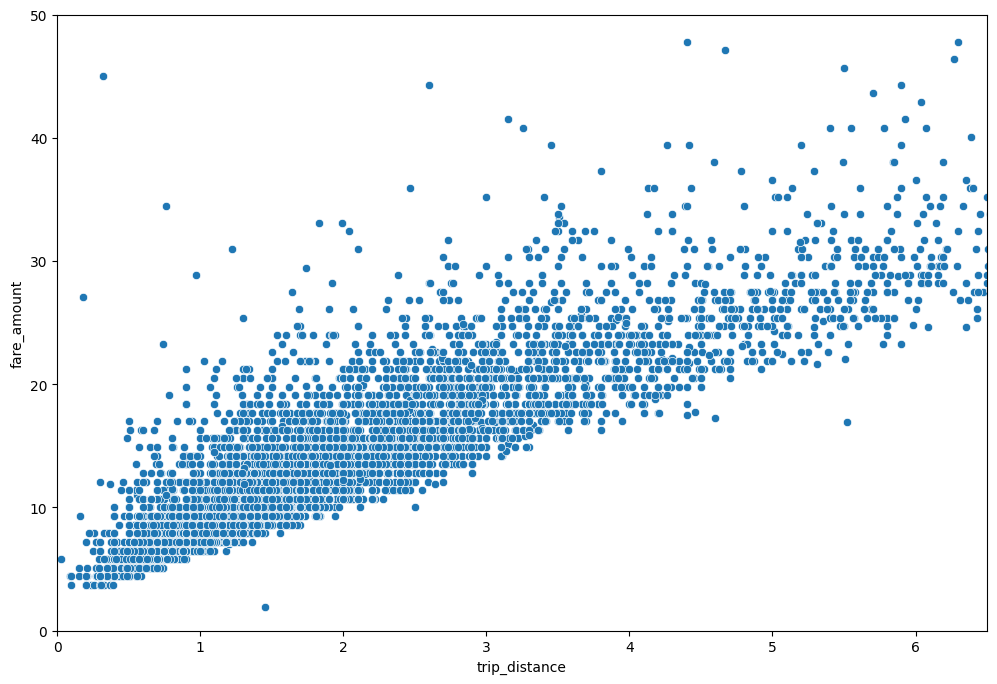

In [ ]:
# Show how trip fare is affected by distance

# count = df6['fare_amount'].median()
# count

## Using ScatterPlot to get the relationship between trip_distance and fare_amount as both are Numerical variables
## Use scatter plot for Numerical - Numerical Bivariate Analysis

plt.figure(figsize = (12,8))
sns.scatterplot(data = df7, x = 'trip_distance', y = 'fare_amount')
plt.ylim(0,50)
plt.xlim(0,6.5)
plt.show()


In [ ]:
## Correlation between trip_distance and fare_amount

Corr_trip_fare = df7['trip_distance'].corr(df7['fare_amount'])
Corr_trip_fare

# plt.figure(figsize=(9,5))
# sns.heatmap(df7[["trip_distance","fare_amount"]].corr(), annot= True , cmap = "Reds")
# plt.show()

np.float64(0.8479518634551424)

In [284]:
df7.to_parquet('df7_trip_fare.parquet')

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [288]:
## Reduce the data till 5 lacks =  580504
df8 = df7.sample(frac=0.4, random_state=42)
# # df8.groupby("Pickup_days")['total_amount'].sum()
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565161 entries, 1863844 to 575350
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               565161 non-null  int64         
 1   tpep_pickup_datetime   565161 non-null  datetime64[us]
 2   tpep_dropoff_datetime  565161 non-null  datetime64[us]
 3   passenger_count        565161 non-null  float64       
 4   trip_distance          565161 non-null  float64       
 5   RatecodeID             565161 non-null  float64       
 6   store_and_fwd_flag     565161 non-null  object        
 7   PULocationID           565161 non-null  int64         
 8   DOLocationID           565161 non-null  int64         
 9   payment_type           565161 non-null  int64         
 10  fare_amount            565161 non-null  float64       
 11  tip_amount             565161 non-null  float64       
 12  tolls_amount           565161 non-null  flo

In [292]:
# Show relationship between fare and trip duration

#df8['trip_duration_sec'] = (df8['tpep_dropoff_datetime'] - df8['tpep_pickup_datetime']).dt.total_seconds()
df8['trip_duration'] = df8['trip_duration_sec'] / 60 
df8.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1863844         2  2023-11-24 18:09:32   2023-11-24 18:27:00              1.0   
1170990         2  2023-10-16 11:54:46   2023-10-16 12:35:52              1.0   
576526          1  2023-03-24 15:18:28   2023-03-24 15:42:46              2.0   
1619478         2  2023-08-06 21:18:39   2023-08-06 21:23:59              2.0   
389932          2  2023-04-20 16:00:30   2023-04-20 16:33:51              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1863844           6.85         1.0                  N           138   
1170990           3.02         1.0                  N            68   
576526            6.85         1.0                  N           138   
1619478           1.34         1.0                  N           170   
389932            4.81         1.0                  N           236   

         DOLocationID  payment_type  fare_amount  tip_amount  tolls_amount  \
1863844            58             1         37.3        6.85          6.94   
1170990           141             1         33.1        1.00          0.00   
576526            229             1         34.5        6.85          6.55   
1619478            79             1          7.9        3.00          0.00   
389932            249             1         31.7        6.85          0.00   

         extra  mta_tax  improvement_surcharge  congestion_surcharge  \
1863844   7.50      0.5                    1.0                   0.0   
1170990   0.00      0.5                    1.0                   2.5   
576526    8.75      0.5                    1.0                   2.5   
1619478   1.00      0.5                    1.0                   2.5   
389932    2.50      0.5                    1.0                   2.5   

         Airport_Fee  total_amount  Pickup_hour  Pickup_days  Pickup_month  \
1863844         1.75         65.64           18            4            11   
1170990         0.00         38.10           11            0            10   
576526          1.25         61.55           15            4             3   
1619478         0.00         15.90           21            6             8   
389932          0.00         45.84           16            3             4   

         Quarter  trip_duration_sec  trip_duration  
1863844        4             1048.0      17.466667  
1170990        4             2466.0      41.100000  
576526         1             1458.0      24.300000  
1619478        3              320.0       5.333333  
389932         2             2001.0      33.350000

In [294]:
count = df8['fare_amount'].mode()
count

0    8.6
Name: fare_amount, dtype: float64

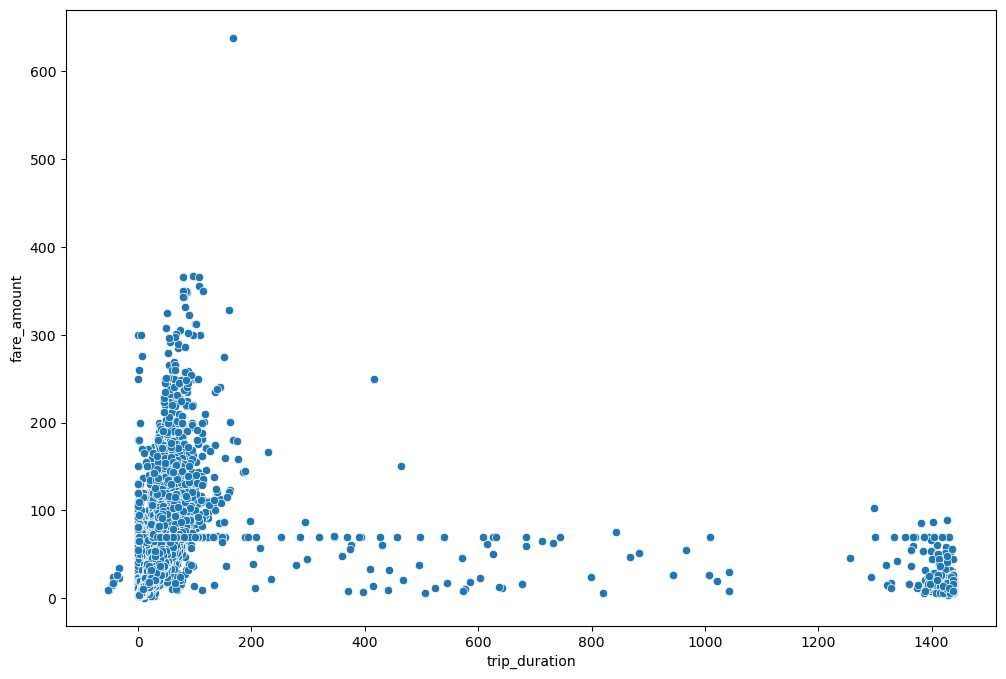

In [296]:

plt.figure(figsize = (12,8))
sns.scatterplot(data = df8, x = 'trip_duration', y = 'fare_amount')
# plt.ylim(0,100)
# plt.xlim(0,600)
plt.show()

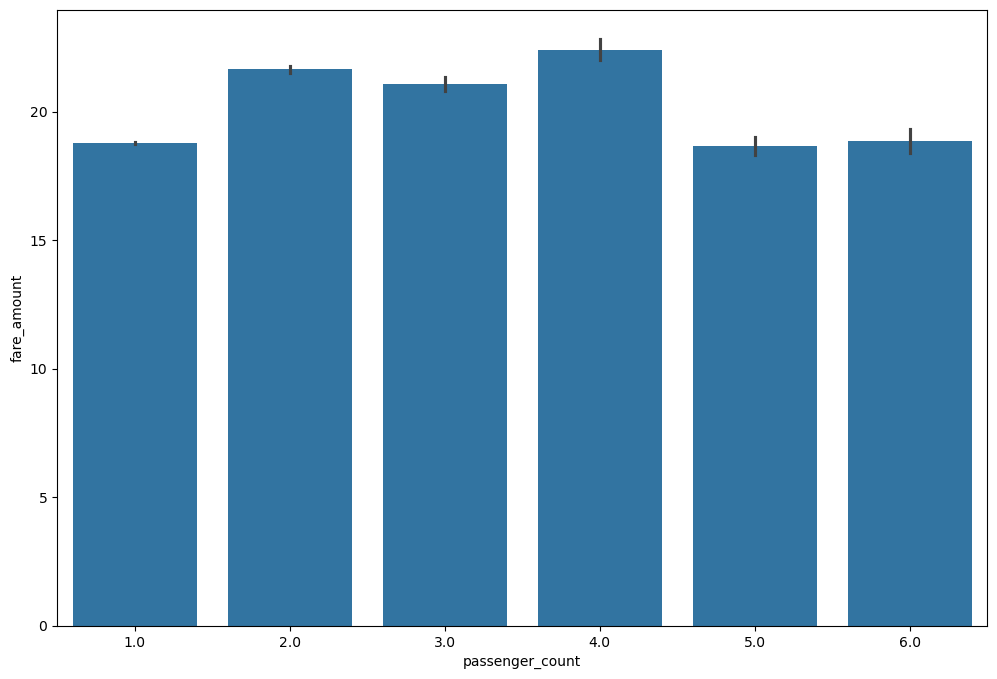

In [298]:
# Show relationship between fare and number of passengers

plt.figure(figsize = (12,8))


sns.barplot(data = df8, x="passenger_count", y="fare_amount", estimator="mean")
# plt.ylim(0,100)
# plt.xlim(0,600)
plt.show()

# sns.boxplot(data=df8, x="passenger_count", y="fare_amount")
# plt.title("Fare Amount by Number of Passengers")
# plt.xlabel("Passenger Count")
# plt.ylabel("Fare Amount ($)")
# plt.show()

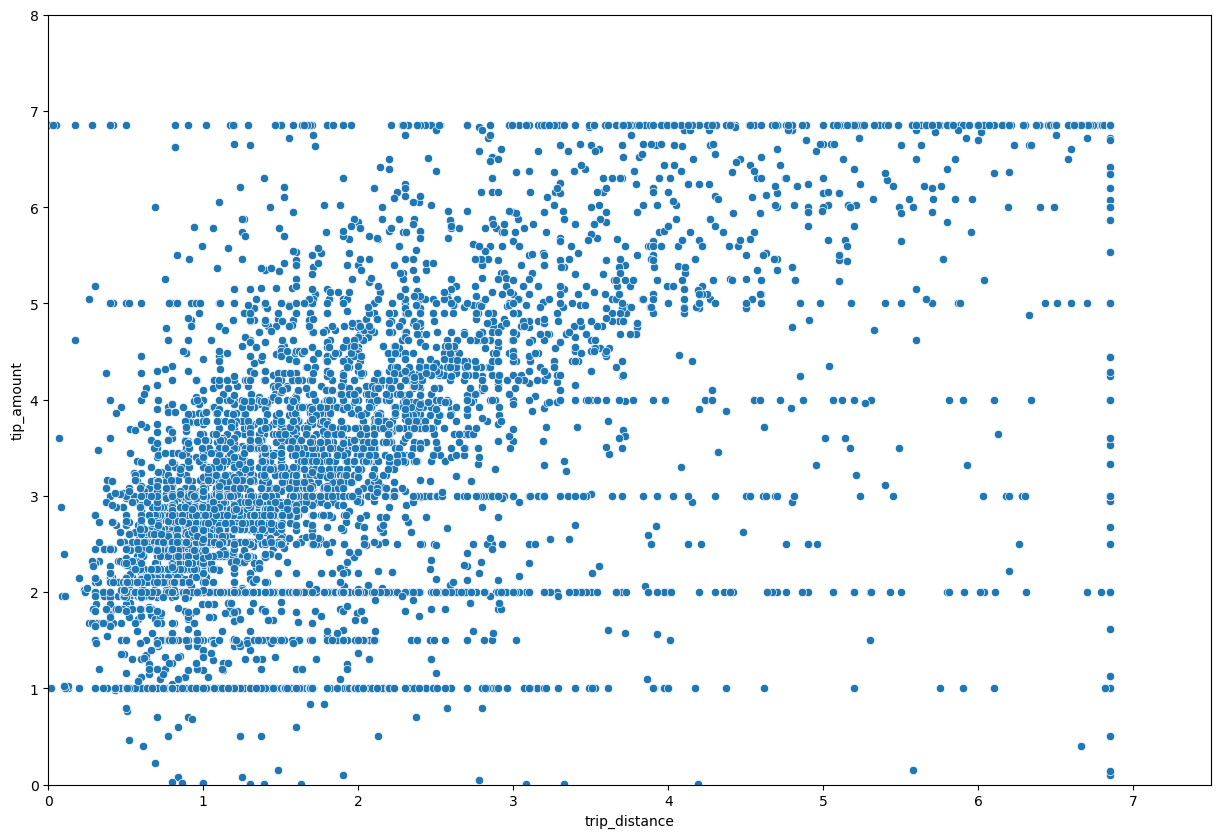

In [308]:
# Show relationship between tip and trip distance
# count = df8['tip_amount'].max()
# count
### sample the data for scatter plot
df9 = df8.sample(frac=0.01, random_state=42)
# df9.info()
plt.figure(figsize = (15,10))
sns.scatterplot(data = df9 , x = 'trip_distance', y = 'tip_amount')
plt.ylim(0, 8)
plt.xlim(0,7.5)
plt.show()

# sns.heatmap(df9[["trip_distance","tip_amount"]].corr(), annot= True , cmap = "Reds")
# plt.show()


In [310]:
## The Df8 File

df8.to_parquet('df8_EDA_Version1.parquet')
# df8.info()

# df8 = pd.read_parquet('df8_EDA_Version1.parquet')
# df8.info()

# count = df8[df8['trip_duration'] <0 ]
# count

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

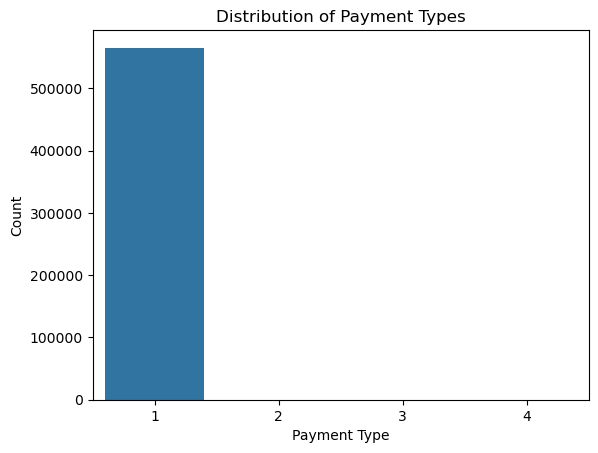

In [312]:
# Analyse the distribution of different payment types (payment_type).

sns.countplot(data=df8, x="payment_type")
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.show()



- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [316]:
!pip install geopandas

   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.2 MB 10.1 MB/s eta 0:00:02
   ------- -------------------------------- 2.9/16.2 MB 7.6 MB/s eta 0:00:02
   ----------- ---------------------------- 4.5/16.2 MB 7.3 MB/s eta 0:00:02
   ------------ --------------------------- 5.2/16.2 MB 6.5 MB/s eta 0:00:02
   ---------------- ----------------------- 6.6/16.2 MB 6.4 MB/s eta 0:00:02
   -------------------- ------------------- 8.1/16.2 MB 6.5 MB/s eta 0:00:02
   ----------------------- ---------------- 9.4/16.2 MB 6.3 MB/s eta 0:00:02
   ------------------------- -------------- 10.5/16.2 MB 6.1 MB/s eta 0:00:01
   ---------------------------- ----------- 11.5/16.2 MB 6.1 MB/s eta 0:00:01
   ------------------------------- -------- 12.8/16.2 MB 6.1 MB/s eta 0:00:01
   ----------------------------------- ---- 14.4/16.2 MB 6.1 MB/s eta 0:00:01
   -------------------------------------- - 15.7/16.2 MB 6.2 MB/s eta 0:00:01


In [318]:
import geopandas as gpd
import os

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [322]:
# # # Read the shapefile using geopandas
zones = gpd.read_file(r'C:\Users\Anuja\Desktop\Data_Study_Upgrad\EDA\EDA_Assignment\taxi_zones\taxi_zones.shp') # read the .shp file using gpd
zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [324]:
zones.plot()

<Axes: >

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [342]:
df9.groupby(['Pickup_hour','Pickup_days','Pickup_month']).count()

VendorID  tpep_pickup_datetime  \
Pickup_hour Pickup_days Pickup_month                                   
0           0           1                    2                     2   
                        4                    2                     2   
                        7                    1                     1   
                        10                   2                     2   
            1           2                    1                     1   
                        3                    3                     3   
                        4                    2                     2   
                        5                    1                     1   
                        6                    1                     1   
                        8                    1                     1   
                        9                    2                     2   
                        10                   1                     1   
                        11                   1                     1   
            2           1                    3                     3   
                        3                    2                     2   
                        5                    1                     1   
                        6                    1                     1   
                        7                    1                     1   
                        8                    1                     1   
                        9                    1                     1   
                        12                   1                     1   
            3           2                    1                     1   
                        3                    2                     2   
                        4                    2                     2   
                        5                    2                     2   
                        6                    2                     2   
                        7                    2                     2   
                        8                    2                     2   
                        10                   3                     3   
                        11                   1                     1   
                        12                   1                     1   
            4           1                    4                     4   
                        2                    1                     1   
                        3                    2                     2   
                        4                    2                     2   
                        5                    4                     4   
                        6                    3                     3   
                        9                    2                     2   
                        10                   6                     6   
                        11                   1                     1   
                        12                   1                     1   
            5           1                    4                     4   
                        2                    3                     3   
                        4                    2                     2   
                        5                    4                     4   
                        6                    2                     2   
                        7                    3                     3   
                        8                    2                     2   
                        9                    2                     2   
                        10                   2                     2   
                        11                   2                     2   
                        12                   3                     3   
            6           1                    3                     3   
                        2                    4                     4   
      

In [337]:
# Merge zones and trip records using locationID and PULocationID

# df_merged_1 = pd.merge(df8, zones, left_on = 'PULocationID', right_on = 'LocationID')

df_merged_1.info()
#df_merged_1.to_csv("df_merged_V1.csv")

OSError: [Errno 28] No space left on device

In [344]:
Trip_Count = df_merged_1['LocationID'].value_counts()
Trip_Count.reset_index(name = 'Trip_Count')

LocationID  Trip_Count
0           237       27980
1           161       27194
2           132       25544
3           236       25318
4           162       20932
5           138       20560
6           142       19779
7           186       19328
8           230       17829
9           170       17278
10          163       16701
11          239       16423
12          234       16266
13           68       15128
14           48       14593
15           79       13849
16          141       13804
17          249       13589
18          164       13270
19          107       12288
20          140       11358
21          229       11294
22          263       11202
23          238       11177
24          246        9682
25           43        9565
26           90        9490
27          100        8506
28          113        8088
29          114        7941
30          231        7879
31          262        7623
32          233        7050
33          143        6112
34          137        5997
35          148        5986
36          158        5119
37          144        5088
38          211        4395
39          151        4221
40           13        3434
41           50        3369
42          125        3048
43           87        2902
44          261        2728
45           70        2587
46           75        2577
47          166        2370
48           88        1357
49           24        1323
50          209        1014
51           41         850
52           45         699
53           74         662
54          224         645
55            4         566
56          232         528
57           65         256
58          152         213
59          116         206
60           12         196
61          226         193
62           33         176
63          244         175
64          145         163
65          146         150
66           42         143
67           66         139
68          255         130
69           10         126
70           25         120
71          181         115
72            7         111
73          256         104
74           93          99
75           97          99
76           52          89
77           80          65
78          223          63
79          216          58
80           40          58
81          129          48
82          260          47
83          112          46
84          215          40
85          130          34
86          157          32
87           82          31
88          195          29
89           56          28
90          193          28
91          134          25
92          189          25
93          243          23
94          219          23
95          179          23
96           28          22
97           95          19
98           49          19
99          197          17
100          61          16
101         194          14
102         190          13
103          36          13
104         168          13
105           1          13
106          17          12
107         127          11
108         202          10
109         247           9
110         228           8
111         217           8
112         196           8
113          76           8
114         106           8
115          89           8
116          37           7
117          54           7
118         188           7
119          83           7
120         207           6
121          34           6
122          62           6
123         200           5
124         198           5
125         124           5
126         225           5
127         133           4
128         155           4
129          92           4
130         220           4
131         120           4
132         121           4
133         212           4
134         119           4
135          14           4
136         257           3
137          55           3
138         123           3
139          26           3
140         180           3
141         218           3
1

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [350]:
# Group data by location and calculate the number of trips
#df_merged_1['LocationID'].max()

# Trip_Count = df_merged_1.groupby('LocationID')['LocationID'].count()
# Trip_Count

# Group_data = Trip_Count.reset_index(name = 'Trip_Count').sort_values(by = 'Trip_Count', ascending = False)
# Group_data.rename(columns={'LocationID': 'Location1'})

Group_data = (Trip_Count.reset_index(name='Trip_Count').rename(columns={'LocationID': 'Location1'}).sort_values(by='Trip_Count', ascending=False))
Group_data


Location1  Trip_Count
173        237       27980
114        161       27194
91         132       25544
172        236       25318
115        162       20932
97         138       20560
100        142       19779
132        186       19328
167        230       17829
122        170       17278
116        163       16701
175        239       16423
171        234       16266
46          68       15128
32          48       14593
55          79       13849
99         141       13804
184        249       13589
117        164       13270
73         107       12288
98         140       11358
166        229       11294
194        263       11202
174        238       11177
181        246        9682
29          43        9565
62          90        9490
69         100        8506
76         113        8088
77         114        7941
168        231        7879
193        262        7623
170        233        7050
101        143        6112
96         137        5997
105        148        5986
111        158        5119
102        144        5088
150        211        4395
106        151        4221
8           13        3434
34          50        3369
84         125        3048
59          87        2902
192        261        2728
48          70        2587
52          75        2577
119        166        2370
60          88        1357
15          24        1323
149        209        1014
27          41         850
30          45         699
51          74         662
161        224         645
1            4         566
169        232         528
44          65         256
107        152         213
78         116         206
7           12         196
163        226         193
20          33         176
180        244         175
103        145         163
104        146         150
28          42         143
45          66         139
187        255         130
5           10         126
16          25         120
130        181         115
2            7         111
188        256         104
67          97          99
65          93          99
35          52          89
56          80          65
160        223          63
154        216          58
26          40          58
88         129          48
191        260          47
75         112          46
153        215          40
89         130          34
110        157          32
57          82          31
140        195          29
38          56          28
138        193          28
93         134          25
134        189          25
128        179          23
157        219          23
179        243          23
18          28          22
66          95          19
33          49          19
142        197          17
40          61          16
139        194          14
120        168          13
135        190          13
23          36          13
0            1          13
11          17          12
86         127          11
145        202          10
182        247           9
61          89           8
155        217           8
141        196           8
72         106           8
53          76           8
165        228           8
58          83           7
133        188           7
24          37           7
36          54           7
21          34           6
41          62           6
147        207           6
144        200           5
143        198           5
83         124           5
162        225           5
151        212           4
158        220           4
79         119           4
80         120           4
81         121           4
64          92           4
109        155           4
9           14           4
92         133           4
156        218           3
189        257           3
37          55           3
82         123           3
17          26           3
129        180           3
113        160           2
121        169           2
4            9           2
47          69           2
177        241           2
50       

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [352]:
# Merge trip counts back to the zones GeoDataFrame

df_merged_tripcount = pd.merge(zones, Group_data, left_on = 'LocationID', right_on = 'Location1')
# df_merged_tripcount.info()
df_merged_tripcount.head(3)

OBJECTID  Shape_Leng  Shape_Area            zone  LocationID    borough  \
0         1    0.116357    0.000782  Newark Airport           1        EWR   
1         4    0.043567    0.000112   Alphabet City           4  Manhattan   
2         7    0.107417    0.000390         Astoria           7     Queens   

                                            geometry  Location1  Trip_Count  
0  POLYGON ((933100.918 192536.086, 933091.011 19...          1          13  
1  POLYGON ((992073.467 203714.076, 992068.667 20...          4         566  
2  POLYGON ((1010804.218 218919.641, 1011049.165 ...          7         111

In [368]:
df_merged_tripcount.to_csv("Zone_wise_trip.csv")

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

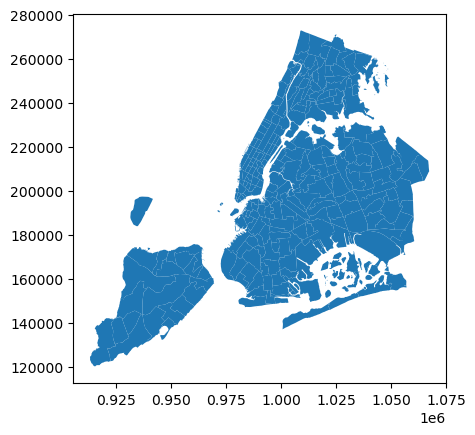

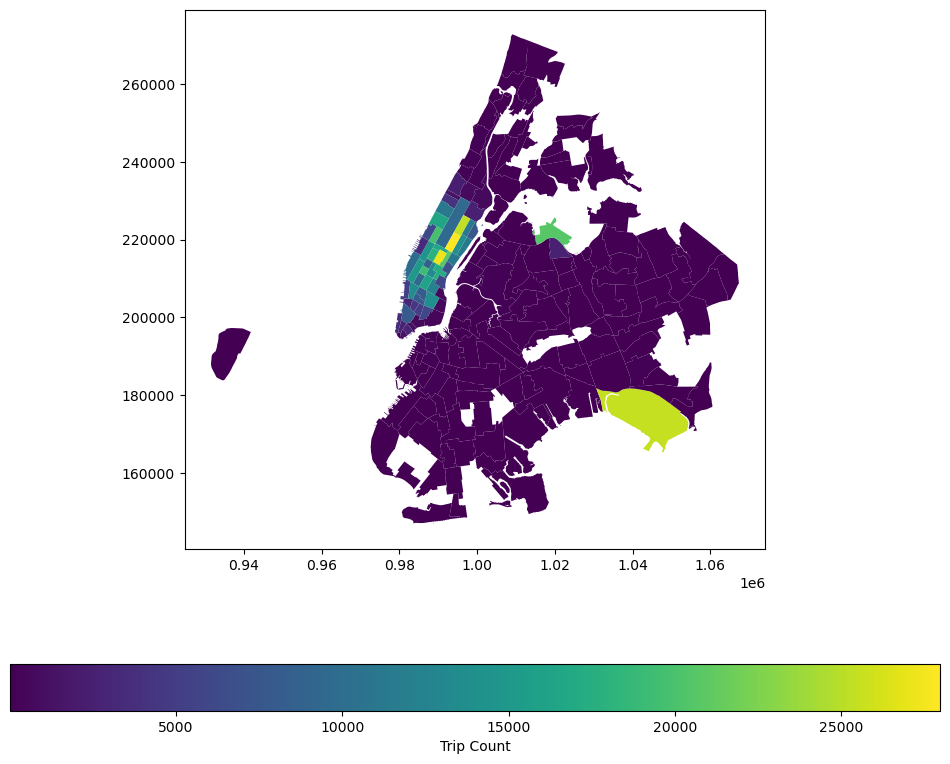

In [356]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

df_merged_tripcount.plot(column = 'Trip_Count', ax = ax, legend = True, legend_kwds = {'label': "Trip Count", 'orientation': "horizontal"})
plt.show()

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [364]:
# Define figure and axis
# df_merged_tripcount.info()
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it
df_merged_tripcount.plot(column = 'zone', ax = ax, legend = True, legend_kwds = {'label': "zone", 'orientation': "horizontal"})
plt.show()


TypeError: Legend.__init__() got an unexpected keyword argument 'label'

In [366]:
# can you try displaying the zones DF sorted by the number of trips?

sorted_df = df_merged_tripcount.sort_values(by='Trip_Count', ascending=False)
sorted_df.head()


OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
174       237    0.042213    0.000096  Upper East Side South         237   
115       161    0.035804    0.000072         Midtown Center         161   
92        132    0.245479    0.002038            JFK Airport         132   
173       236    0.044252    0.000103  Upper East Side North         236   
116       162    0.035270    0.000048           Midtown East         162   

       borough                                           geometry  Location1  \
174  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...        237   
115  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...        161   
92      Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...        132   
173  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...        236   
116  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...        162   

     Trip_Count  
174       27980  
115       27194  
92        25544  
173       25318  
116       20932

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [372]:
zone1 = zones
zone1.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

In [422]:
# Find routes which have the slowest speeds at different times of the day

# zone1.rename(columns = {'LocationID': 'Location','zone':'PickupZone'}, inplace = True)
# zone1.info()

# df_merged_2 = df_merged_1.merge(zone1[['Location','PickupZone']], how='left', left_on='PULocationID', right_on='Location')
# df_merged_2.info()
# df_merged_2.drop(columns=['Unnamed: 0','Location'], inplace=True)
# df_merged_2.info()

# zone1.rename(columns = {'PickupZone':'DropZone'}, inplace = True)
# zone1.info()

# df_merged_3 = df_merged_2.merge(zone1[['Location','DropZone']], how='left', left_on='DOLocationID', right_on='Location')
# df_merged_3.info()
# df_merged_3.drop(columns=['Location'], inplace=True)
# df_merged_3.info()

######################### Write the CSV file to Drive ###################
#df_merged_3.to_csv("df_merged_V3.csv")

######################################## Start from here 06/04
#### NOTE : df_merged_4 if for Route details


# df_merged_4  = df_merged_3
# df_merged_4.info()

# # 2. Define route
# df_merged_4['Route'] = df_merged_4['PickupZone'] + " ➜ " + df_merged_4['DropZone']
# df_merged_4.head()

############ Check for any -ve rtip distance

# count = df_merged_4['trip_duration'] < 0
# count.value_counts()

#df_merged_4_1 = df_merged_4[~(df_merged_4['trip_duration'] < 0)]
#df_merged_4 = df_merged_4_1

# # 3. Group by route and hour to calculate average duration and distance
#route_stats = df_merged_4.groupby(['Route', 'Pickup_hour']).agg({'trip_distance': 'mean','trip_duration': 'mean'}).reset_index()
#route_stats.to_csv("route_stats.csv")
#route_stats.info()

# # 4. Calculate speed (distance per hour)

# route_stats['Speed'] = route_stats['trip_distance'] / (route_stats['trip_duration'] /60)  # convert minutes to hours
# route_stats.head()

##################### There are some -ve Trip Duration. Root Cause is there are some entries where Pick time is more than Drop Time
##################### Removign such records

#route_stats_1 = route_stats[route_stats['trip_duration'] > 0 ]



# # 5. Identify slowest routes (lowest speed)
slow_routes = route_stats_1.sort_values(by='Speed').head(10)  # or .query("Speed < X")
slow_routes






Route  Pickup_hour  \
10025             East Elmhurst ➜ LaGuardia Airport            6   
4062           Central Park ➜ Upper West Side North            1   
60019            UN/Turtle Bay South ➜ Clinton East           23   
43049        Midtown Center ➜ Upper West Side North            7   
5800                 Clinton East ➜ Pelham Bay Park            1   
52                     Alphabet City ➜ East Chelsea           20   
49260                       Murray Hill ➜ Hudson Sq            2   
34943          Lincoln Square East ➜ Manhattanville           20   
20143  Greenwich Village North ➜ DUMBO/Vinegar Hill           12   
73383                 Yorkville West ➜ Central Park           23   

       trip_distance  trip_duration     Speed  
10025           1.49    1042.566667  0.085750  
4062            2.31    1390.933333  0.099645  
60019           1.36     721.225000  0.113141  
43049           2.74    1395.500000  0.117807  
5800            0.14      65.666667  0.127919  
52              3.14    1438.700000  0.130952  
49260           3.07    1399.983333  0.131573  
34943           3.38    1438.266667  0.141003  
20143           3.43    1428.583333  0.144059  
73383           1.31     467.900000  0.167985

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [428]:
# Visualise the number of trips per hour and find the busiest hour
## Use df_merged_4

# Trips_per_hour = df_merged_4.groupby("Pickup_hour").size()
# Trips_per_hour.reset_index()

##find the busiest hour

bussiest_hour = df_merged_4.groupby("Pickup_hour").size().idxmax()
bussiest_hour


## Visualization

# sns.barplot(x=Trips_per_hour.index, y=Trips_per_hour.values)
# plt.xlabel("Hour of the Day")
# plt.ylabel("Number of Trips")
# plt.title("Number of Trips per Hour")
# plt.show()


18

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [ ]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.08

scaling_factor = 1 / sample_fraction
trips_per_hour_scaled = Trips_per_hour * scaling_factor
trips_per_hour_scaled

Pickup_hour
0     201825.0
1     136912.5
2      86950.0
3      53712.5
4      33512.5
5      35162.5
6      93200.0
7     198100.0
8     278825.0
9     307937.5
10    325875.0
11    350850.0
12    376175.0
13    391862.5
14    416562.5
15    436562.5
16    445300.0
17    492087.5
18    522137.5
19    473275.0
20    421225.0
21    420262.5
22    392187.5
23    302787.5
dtype: float64

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [438]:
# Compare traffic trends for the week days and weekends

################### Take a Copy of df_merged_4 ###############################
# df_merged_5 = df_merged_4

####################### Identify the Dat type
# df_merged_5['day_type'] = df_merged_5['Pickup_days'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
# df_merged_5.head(3)

#################### Compare traffic trends for the week days and weekends #############################

# trips_by_hour_daytype = df_merged_5.groupby(['Pickup_hour', 'day_type']).size().reset_index(name='trip_count')
trips_by_hour_daytype.sort_values(by = 'trip_count', ascending = False)

Pickup_hour day_type  trip_count
36           18  Weekday       31823
34           17  Weekday       28795
38           19  Weekday       27843
42           21  Weekday       25525
40           20  Weekday       25436
32           16  Weekday       25166
30           15  Weekday       24875
28           14  Weekday       24136
44           22  Weekday       22965
26           13  Weekday       21859
24           12  Weekday       21440
22           11  Weekday       20011
18            9  Weekday       19402
20           10  Weekday       19051
16            8  Weekday       18553
46           23  Weekday       16824
14            7  Weekday       13329
37           18  Weekend        9526
35           17  Weekend        9461
33           16  Weekend        9323
31           15  Weekend        9039
29           14  Weekend        8858
39           19  Weekend        8824
27           13  Weekend        8603
25           12  Weekend        8401
1             0  Weekend        8173
0             0  Weekday        7765
41           20  Weekend        7717
43           21  Weekend        7586
45           22  Weekend        7477
23           11  Weekend        7326
47           23  Weekend        6790
3             1  Weekend        6778
21           10  Weekend        6151
12            6  Weekday        5859
5             2  Weekend        4801
19            9  Weekend        4562
2             1  Weekday        3758
7             3  Weekend        3090
17            8  Weekend        2722
10            5  Weekday        2008
4             2  Weekday        1911
15            7  Weekend        1640
9             4  Weekend        1435
6             3  Weekday        1093
13            6  Weekend        1029
8             4  Weekday         958
11            5  Weekend         616

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [442]:
# Find top 10 pickup and dropoff zones

########## Use df_merged_5
#df_merged_5.info()
############# Find top 10 pickup Zones

# Top_Pickup_zone = df_merged_5.groupby(["Pickup_hour","PickupZone"]).size()
# Top_Pickup_zone1  = Top_Pickup_zone.reset_index(name ='Trip_Count' )
# Top_Pickup_zone1.sort_values(by = 'Trip_Count', ascending = False).head(10)

############# Find top 10 dropoff zones

Top_Drop_zone = df_merged_5.groupby(["Pickup_hour","DropZone"]).size()
Top_Drop_zone1  = Top_Drop_zone.reset_index(name ='Trip_Count' )
Top_Drop_zone1.sort_values(by = 'Trip_Count', ascending = False).head(10)


Pickup_hour               DropZone  Trip_Count
3562           18  Upper East Side North        2076
3563           18  Upper East Side South        2042
2712           14  Upper East Side North        2025
3347           17  Upper East Side North        1973
2926           15  Upper East Side North        1970
2314           12  Upper East Side South        1929
3138           16  Upper East Side North        1858
3348           17  Upper East Side South        1849
2927           15  Upper East Side South        1848
1477            8         Midtown Center        1814

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [458]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
#########df_merged_5

#### Step 1
# pickup_counts = df_merged_5['PickupZone'].value_counts()
# pickup_counts
# dropoff_counts = df_merged_5['DropZone'].value_counts()
# dropoff_counts

### Step2
# zone_stats_ratio = pd.DataFrame({
# 'pickup_count': pickup_counts,
# 'dropoff_count': dropoff_counts
# }).fillna(0)
# zone_stats_ratio

# ### Step 3
# zone_stats_ratio['pickup_dropoff_ratio'] = zone_stats_ratio['pickup_count'] / zone_stats_ratio['dropoff_count'].replace(0, np.nan)
# zone_stats_ratio

# ### Step 4
# top_10 = zone_stats_ratio.sort_values(by='pickup_dropoff_ratio', ascending=False).head(10)
# top_10
#bottom_10 = zone_stats_ratio.sort_values(by='pickup_dropoff_ratio', ascending=True).head(10)

# print("Top 10 Zones by Pickup/Dropoff Ratio:")
# print(top_10)

# print("\nBottom 10 Zones by Pickup/Dropoff Ratio:")
bottom_10


pickup_count  dropoff_count  \
Allerton/Pelham Gardens                     0.0             26   
Erasmus                                     0.0             56   
Eltingville/Annadale/Prince's Bay           0.0              4   
Eastchester                                 0.0             17   
East Tremont                                0.0             12   
Rockaway Park                               0.0             44   
Madison                                     0.0             48   
Rossville/Woodrow                           0.0              1   
Saint Albans                                0.0             62   
Dyker Heights                               0.0             45   

                                   pickup_dropoff_ratio  
Allerton/Pelham Gardens                             0.0  
Erasmus                                             0.0  
Eltingville/Annadale/Prince's Bay                   0.0  
Eastchester                                         0.0  
East Tremont                                        0.0  
Rockaway Park                                       0.0  
Madison                                             0.0  
Rossville/Woodrow                                   0.0  
Saint Albans                                        0.0  
Dyker Heights                                       0.0

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [468]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

########## Use df_merged_5
# df_merged_5_night = df_merged_5
# ### Step 1 - Get the night time Data
# df_merged_5_night = df_merged_5[(df_merged_5['Pickup_hour'] >= 23) | (df_merged_5['Pickup_hour'] <= 4)]

#### Step 2 - Get the Pick Up and Drop Zones Trip counts

# Night_Pickup_Count = df_merged_5_night.groupby('PickupZone').size()
# Night_Pickup_Count_1 = Night_Pickup_Count.reset_index(name = 'Trip_Count')
# Night_Pickup_Count_1.sort_values(by = 'Trip_Count', ascending = False).head(10)

Night_Drop_Count = df_merged_5_night.groupby('DropZone').size()
Night_Drop_Count_1 = Night_Drop_Count.reset_index(name = 'Trip_Count')
Night_Drop_Count_1.sort_values(by = 'Trip_Count', ascending = False).head(10)

DropZone  Trip_Count
70            East Village        2699
41            Clinton East        2000
153            Murray Hill        1943
94                Gramercy        1935
59            East Chelsea        1753
126        Lenox Hill West        1743
226           West Village        1688
239         Yorkville West        1622
216  Upper West Side South        1491
213  Upper East Side North        1468

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [ ]:
#df_merged_5.to_csv("df_merged_V5.csv")

In [484]:
# Filter for night hours (11 PM to 5 AM)
#df_merged_5.info()
##### USE Copy  of df_merged_5

# df_merged_6 = df_merged_5


# ######## Step 1 -  Categorise as Day or Night
# df_merged_6['time_period'] = df_merged_6['Pickup_hour'].apply(lambda x: 'Night' if x in [23, 0, 1, 2, 3, 4, 5] else 'Day')
# df_merged_6.head()

######## Step 2 - Group by time_period and get the sum()
# Group_sum = df_merged_6.groupby('time_period')['total_amount'].sum()
# Group_sum

# ########### STEP 3 - get total Sum
# total_sum = Group_sum.sum()
# total_sum

########## STEP 4 - GEt teh Revenue Share

Revenue_share = (Group_sum / total_sum)*100
Revenue_share

time_period
Day      88.049734
Night    11.950266
Name: total_amount, dtype: float64

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [494]:
# Analyse the fare per mile per passenger for different passenger counts

########### USE df_merged_6
###### Step 1 - check if any value in passenger count, fare or distance is <= 0
#df_merged_6[df_merged_6['trip_distance'] <= 0].shape[0]

#df_Night_Price = df_merged_5_night

# #### Step 2 -  Find fare per mile per passanger
# df_merged_6['fare_mile_pass'] = df_merged_6['fare_amount'] / (df_merged_6['trip_distance'] * df_merged_6['passenger_count'])
# df_merged_6.head()

#### Step 3 - Group by Passenger Count and get avg on fare per mile per passanger

Group1 = df_merged_6.groupby('passenger_count')['fare_mile_pass'].mean()
Group1.reset_index()


passenger_count  fare_mile_pass
0              1.0        9.664401
1              2.0        5.230272
2              3.0        3.388922
3              4.0        3.753446
4              5.0        1.602497
5              6.0        1.362517

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [496]:
#### Write the df_merged_6

df_merged_6.to_csv("df_merged_V6.csv")

In [506]:
####Find the average fare per mile by hours of the day and by days of the week

####################### USE df_merged_6 ######################

######### step1 - Check distance and total amount is > 0
# df_merged_6[df_merged_6['fare_amount']<=0].shape[0]

######### step2 - Get the Average fare per mile
# df_merged_6['Avg_fare_per_mile'] = df_merged_6['fare_amount'] / df_merged_6['trip_distance']
# df_merged_6.head(4)

########### Step 3 - Find the average fare per mile by hours of the day

# Avg_fare_by_hours = df_merged_6.groupby("Pickup_hour")['Avg_fare_per_mile'].mean()
# Avg_fare_by_hours.reset_index()


########### Step 4 - Find the average fare per mile by days of a week

Avg_fare_by_days = df_merged_6.groupby("Pickup_days")['Avg_fare_per_mile'].mean()
Avg_fare_by_days.reset_index()

Pickup_days  Avg_fare_per_mile
0            0           9.616379
1            1           9.837903
2            2           9.879491
3            3          10.258398
4            4           9.890159
5            5           8.983269
6            6          10.589093

In [510]:
# Compare the average fare per mile for different days and for different times of the day
#df_merged_6.info()


#################### Compare the average fare per mile different times of the day
# df_merged_6.info()
# def time_of_day(hour):
#     if 5 <= hour < 12:
#         return "Morning"
#     elif 12 <= hour < 17:
#         return "Afternoon"
#     elif 17 <= hour < 21:
#         return "Evening"
#     else:
#         return "Night"

# df_merged_6["time_of_day"] = df_merged_6["Pickup_hour"].apply(time_of_day)
# df_merged_6.head(4)

Avg_fare_by_time_of_day = df_merged_6.groupby("time_of_day")['Avg_fare_per_mile'].mean()
Avg_fare_by_time_of_day.reset_index()



time_of_day  Avg_fare_per_mile
0   Afternoon          11.253769
1     Evening           9.490973
2     Morning           9.459313
3       Night           8.911228

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [512]:
# Compare fare per mile for different vendors

#df_merged_6.head()
Avg_fare_by_vendors = df_merged_6.groupby("VendorID")['Avg_fare_per_mile'].mean()
Avg_fare_by_vendors.reset_index()


VendorID  Avg_fare_per_mile
0         1           8.348143
1         2          10.381718

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [516]:
# Defining distance tiers

############ USE df_merged_6

############## STEP 1  -  Define the Tiers as per Distance

def distance_tier(distance):
    if distance <= 2:
        return "Tier 1"
    elif 2 < distance <= 5:
        return "Tier 2"
    else:
        return "Tier 3"


df_merged_6['Dist_Tier'] = df_merged_6["trip_distance"].apply(distance_tier)
df_merged_6.head()

############## STEP 1  -  Compare the fare rates of the different vendors in a tiered fashion.

Avg_fare_by_vendors_tier = df_merged_6.groupby(["VendorID","Dist_Tier"])['Avg_fare_per_mile'].mean()
Avg_fare_by_vendors_tier.reset_index()




VendorID Dist_Tier  Avg_fare_per_mile
0         1    Tier 1           9.526110
1         1    Tier 2           6.372280
2         1    Tier 3           7.283243
3         2    Tier 1          13.312372
4         2    Tier 2           6.546986
5         2    Tier 3           7.541810

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [528]:
#  Analyze tip percentages based on distances, passenger counts and pickup times


############ USE df_merged_6

df_merged_6.head()

############## STEP 1  -  Define Tip Percentage

# df_merged_6[df_merged_6['fare_amount'] <= 0].shape[0]

# df_merged_6["tip_percent"] = (df_merged_6["tip_amount"] / df_merged_6["fare_amount"]) * 100


############## STEP 2  -  Get avg Tip% based on Trip Distance

# Tip_by_distance = df_merged_6.groupby("Dist_Tier")["tip_percent"].mean()
# Tip_by_distance.reset_index()

############## STEP 3  -  Get avg Tip% based on Time of Day

# Tip_by_DayTime = df_merged_6.groupby("time_of_day")["tip_percent"].mean()
# Tip_by_DayTime .reset_index()


############## STEP 4  -  Get avg Tip% based on Passenger Count

Tip_by_PassNo = df_merged_6.groupby("passenger_count")["tip_percent"].mean()
Tip_by_PassNo .reset_index()


passenger_count  tip_percent
0              1.0    24.730468
1              2.0    23.946682
2              3.0    24.016297
3              4.0    23.900318
4              5.0    24.669856
5              6.0    24.643895

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

############# df_merged_6

#Trips_less_10Per = df_merged_6.loc[(df_merged_6['tip_percent'] < 10)]
Trips_less_10Per.size


#Trips_more_25Per = df_merged_6.loc[(df_merged_6['tip_percent'] > 10)]
#Trips_more_25Per.size

2301371

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [532]:
# See how passenger count varies across hours and days

#############
#df_merged_6.head()

######### STEP1  - Analyse the variation of passenger count across hours

# Pass_count_by_hour = df_merged_6.groupby("Pickup_hour")["passenger_count"].count()
# Pass_count_by_hour.reset_index()

######## STEP 2 -  Analyse the variation of passenger count across days of the week.

Pass_count_by_day = df_merged_6.groupby("Pickup_days")["passenger_count"].count()
Pass_count_by_day.reset_index()


Pickup_days  passenger_count
0            0            69028
1            1            81923
2            2            87783
3            3            89117
4            4            82534
5            5            80689
6            6            69239

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [ ]:
# How does passenger count vary across zones

############### df_merged_6

df_merged_6.head(3)

Pass_count_by_Zone = df_merged_6.groupby("PickupZone")["passenger_count"].count()
Pass_count_by_Zone.reset_index().sort_values(by = 'passenger_count', ascending = False)

PickupZone  passenger_count
195                Upper East Side South            28366
131                       Midtown Center            27592
194                Upper East Side North            26063
100                          JFK Airport            25549
132                         Midtown East            21455
110                    LaGuardia Airport            20714
114                  Lincoln Square East            20002
151         Penn Station/Madison Sq West            19645
188            Times Sq/Theatre District            18136
139                          Murray Hill            17579
197                Upper West Side South            17192
133                        Midtown North            16985
192                             Union Sq            16434
53                          East Chelsea            15254
35                          Clinton East            14970
64                          East Village            14302
113                      Lenox Hill West            14294
205                         West Village            13984
134                        Midtown South            13694
84                              Gramercy            12765
112                      Lenox Hill East            11655
196                Upper West Side North            11547
217                       Yorkville West            11454
187        Sutton Place/Turtle Bay North            11399
203            West Chelsea/Hudson Yards            10073
32                          Central Park             9769
73                              Flatiron             9709
80                      Garment District             8588
88               Greenwich Village North             8359
189                 TriBeCa/Civic Center             8288
216                       Yorkville East             8222
89               Greenwich Village South             8064
191                  UN/Turtle Bay South             7167
115                  Lincoln Square West             6449
119                      Lower East Side             6178
109                             Kips Bay             6168
128        Meatpacking/West Village West             5413
116                  Little Italy/NoLiTa             5345
122                     Manhattan Valley             4544
171                                 SoHo             4538
37                          Clinton West             3621
7                      Battery Park City             3517
70              Financial District North             3016
96                             Hudson Sq             3014
215                   World Trade Center             2821
60                     East Harlem South             2748
55                         East Elmhurst             2571
136                  Morningside Heights             2534
71              Financial District South             1440
16                          Bloomingdale             1389
169                              Seaport             1035
30                        Central Harlem              973
182       Stuy Town/Peter Cooper Village              722
0                          Alphabet City              707
33                             Chinatown              686
59                     East Harlem North              675
190              Two Bridges/Seward Park              583
51           Downtown Brooklyn/MetroTech              292
22                      Brooklyn Heights              232
90                      Hamilton Heights              224
31                  Central Harlem North              218
184                            Sunnyside              217
209            Williamsburg (North Side)              206
202             Washington Heights South              205
123                       Manhattanville              204
117       Long Island City/Hunters Point              198
6                           Battery Park              194
210            Williamsburg (South Side)              171
49                    DUMBO/

In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [542]:
# How often is each surcharge applied?

##########
df_merged_6.head(3)

#df_merged_6['Total_extra'] = df_merged_6['tolls_amount']+df_merged_6['extra']+df_merged_6['mta_tax']+df_merged_6['improvement_surcharge']+df_merged_6['congestion_surcharge'] + df_merged_6['Airport_Fee']

# df_merged_6['Extra_charges_applied'] = np.where(df_merged_6['Total_extra'] > 0, 1 , 0)
# df_merged_6.head(3)

#df_merged_6['Extra_charges_applied'].value_counts()

# Pick_Zone_with_Extra_Charges = df_merged_6.groupby("PickupZone")['Extra_charges_applied'].sum()
# Pick_Zone_with_Extra_Charges.reset_index().sort_values(by = 'Extra_charges_applied', ascending = False).head(10)

Drop_Zone_with_Extra_Charges = df_merged_6.groupby("DropZone")['Extra_charges_applied'].sum()
Drop_Zone_with_Extra_Charges.reset_index().sort_values(by = 'Extra_charges_applied', ascending = False).head(10)

# Pick_Time_with_Extra_Charges = df_merged_6.groupby("Pickup_hour")['Extra_charges_applied'].sum()
# Pick_Time_with_Extra_Charges.reset_index().sort_values(by = 'Extra_charges_applied', ascending = False).head(10)


DropZone  Extra_charges_applied
227      Upper East Side North                  26924
228      Upper East Side South                  25026
152             Midtown Center                  22113
161                Murray Hill                  17438
230      Upper West Side South                  17245
153               Midtown East                  16630
133        Lincoln Square East                  16589
132            Lenox Hill West                  16033
221  Times Sq/Theatre District                  15796
64                East Chelsea                  14504

In [ ]:
#### WRITE the df_merged_6

#df_merged_6.to_csv("df_merged_V6.csv")
os.getcwd()

'/content/drive/MyDrive/Assignments/EDA/data_NYC_Taxi/taxi_zones'

In [ ]:
# import os
# drive.mount('/content/drive')
# # Select the folder having data files
# os.chdir('/content/drive/My Drive/Assignments/EDA/data_NYC_Taxi/taxi_zones')
# os.getcwd()
#df_merged_6 = pd.read_csv("df_merged_V6.csv")
df_merged_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575463 entries, 0 to 575462
Data columns (total 44 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             575463 non-null  int64  
 1   VendorID               575463 non-null  int64  
 2   tpep_pickup_datetime   575463 non-null  object 
 3   tpep_dropoff_datetime  575463 non-null  object 
 4   passenger_count        575463 non-null  float64
 5   trip_distance          575463 non-null  float64
 6   RatecodeID             575463 non-null  float64
 7   store_and_fwd_flag     575463 non-null  object 
 8   PULocationID           575463 non-null  int64  
 9   DOLocationID           575463 non-null  int64  
 10  payment_type           575463 non-null  float64
 11  fare_amount            575463 non-null  float64
 12  tip_amount             575463 non-null  float64
 13  tolls_amount           575463 non-null  float64
 14  extra                  575463 non-nu

In [ ]:
group1 = df_merged_6.groupby(["time_of_day","PickupZone"])["PickupZone"].count()
group1.reset_index(name = "TripCount").sort_values(by = "TripCount", ascending = False)

time_of_day                           PickupZone  TripCount
158   Afternoon                Upper East Side South      10039
157   Afternoon                Upper East Side North       9516
103   Afternoon                       Midtown Center       9019
261     Evening                       Midtown Center       8856
482     Morning                Upper East Side North       8042
307     Evening                Upper East Side South       7710
545       Night                         East Village       7489
78    Afternoon                          JFK Airport       7281
574       Night                          JFK Airport       7220
85    Afternoon                    LaGuardia Airport       6881
655       Night                         West Village       6787
483     Morning                Upper East Side South       6771
262     Evening                         Midtown East       6757
239     Evening                          JFK Airport       6507
306     Evening                Upper East Side North       6498
104   Afternoon                         Midtown East       6245
447     Morning         Penn Station/Madison Sq West       5809
88    Afternoon                  Lincoln Square East       5723
160   Afternoon                Upper West Side South       5636
249     Evening                  Lincoln Square East       5457
525       Night                         Clinton East       5457
105   Afternoon                        Midtown North       5407
246     Evening                    LaGuardia Airport       5254
119   Afternoon         Penn Station/Madison Sq West       5245
268     Evening                          Murray Hill       5211
111   Afternoon                          Murray Hill       5169
263     Evening                        Midtown North       5165
597       Night                       Midtown Center       5101
431     Morning                         Midtown East       5030
301     Evening            Times Sq/Theatre District       5011
305     Evening                             Union Sq       4984
640       Night            Times Sq/Theatre District       4883
155   Afternoon                             Union Sq       4868
584       Night                  Lincoln Square East       4783
151   Afternoon            Times Sq/Theatre District       4744
485     Morning                Upper West Side South       4714
275     Evening         Penn Station/Madison Sq West       4660
430     Morning                       Midtown Center       4616
406     Morning                          JFK Airport       4541
209     Evening                         East Chelsea       4391
566       Night              Greenwich Village South       4364
413     Morning                    LaGuardia Airport       4328
309     Evening                Upper West Side South       4324
39    Afternoon                         East Chelsea       4287
581       Night                    LaGuardia Airport       4251
87    Afternoon                      Lenox Hill West       4243
24    Afternoon                         Central Park       4153
589       Night                      Lower East Side       4137
437     Morning                          Murray Hill       4097
417     Morning                  Lincoln Square East       4039
644       Night                             Union Sq       4010
86    Afternoon                      Lenox Hill East       4004
484     Morning                Upper West Side North       3958
612       Night         Penn Station/Madison Sq West       3931
248     Evening                      Lenox Hill West       3906
416     Morning                      Lenox Hill West       3854
264     Evening                        Midtown South       3854
647       Night                Upper East Side South       3846
159   Afternoon                Upper West Side North       3798
538       Night                         East Chelsea       3788
415     Morning                      Lenox Hill East       3750
106   Afternoon                     

In [ ]:
group1 = df_merged_6.groupby(["Pickup_days","PickupZone"])["PickupZone"].count()
group1.reset_index(name = "TripCount").sort_values(by = "TripCount", ascending = False)

Pickup_days                           PickupZone  TripCount
375             2                       Midtown Center       5283
424             2                Upper East Side South       5075
575             3                Upper East Side South       4958
526             3                       Midtown Center       4943
229             1                       Midtown Center       4936
272             1                Upper East Side South       4798
574             3                Upper East Side North       4528
423             2                Upper East Side North       4513
950             6                          JFK Airport       4359
63              0                          JFK Airport       4303
271             1                Upper East Side North       4259
724             4                Upper East Side South       4153
723             4                Upper East Side North       3958
376             2                         Midtown East       3939
527             3                         Midtown East       3849
83              0                       Midtown Center       3716
126             0                Upper East Side South       3698
230             1                         Midtown East       3674
680             4                       Midtown Center       3666
780             5                         East Village       3643
205             1                          JFK Airport       3555
69              0                    LaGuardia Airport       3496
125             0                Upper East Side North       3495
656             4                          JFK Airport       3482
352             2                          JFK Airport       3336
507             3                          JFK Airport       3331
872             5                Upper East Side South       3255
512             3                    LaGuardia Airport       3232
362             2                  Lincoln Square East       3191
804             5                          JFK Airport       3183
417             2            Times Sq/Theatre District       3172
211             1                    LaGuardia Airport       3154
956             6                    LaGuardia Airport       3149
382             2                          Murray Hill       3147
515             3                  Lincoln Square East       3108
881             5                         West Village       3093
390             2         Penn Station/Madison Sq West       3087
532             3                          Murray Hill       3058
359             2                    LaGuardia Airport       3040
539             3         Penn Station/Madison Sq West       3016
813             5                  Lincoln Square East       3003
568             3            Times Sq/Theatre District       2998
668             4                  Lincoln Square East       2997
240             1         Penn Station/Madison Sq West       2969
215             1                  Lincoln Square East       2969
665             4                    LaGuardia Airport       2961
377             2                        Midtown North       2953
528             3                        Midtown North       2937
96              0         Penn Station/Madison Sq West       2918
871             5                Upper East Side North       2916
681             4                         Midtown East       2915
84              0                         Midtown East       2879
421             2                             Union Sq       2847
825             5                       Midtown Center       2802
266             1            Times Sq/Theatre District       2789
234             1                          Murray Hill       2765
926             6                         East Village       2731
231             1                        Midtown North       2728
572             3                             Union Sq       2704
983             6         Penn Station/Madison

In [ ]:
group1 = df_merged_6.groupby(["Quarter","PickupZone"])["PickupZone"].count()
group1.reset_index(name = "TripCount").sort_values(by = "TripCount", ascending = False)

Quarter                           PickupZone  TripCount
648        4                Upper East Side South       8003
325        2                Upper East Side South       7639
596        4                       Midtown Center       7457
647        4                Upper East Side North       7391
273        2                       Midtown Center       7202
156        1                Upper East Side South       7074
250        2                          JFK Airport       6999
324        2                Upper East Side North       6939
101        1                       Midtown Center       6802
155        1                Upper East Side North       6673
574        4                          JFK Airport       6365
412        3                          JFK Airport       6288
438        3                       Midtown Center       6131
75         1                          JFK Airport       5897
597        4                         Midtown East       5878
258        2                    LaGuardia Airport       5780
485        3                Upper East Side South       5650
584        4                  Lincoln Square East       5583
581        4                    LaGuardia Airport       5577
274        2                         Midtown East       5521
261        2                  Lincoln Square East       5393
102        1                         Midtown East       5385
610        4         Penn Station/Madison Sq West       5171
87         1                  Lincoln Square East       5072
484        3                Upper East Side North       5060
119        1         Penn Station/Madison Sq West       5013
289        2         Penn Station/Madison Sq West       4920
641        4            Times Sq/Theatre District       4809
421        3                    LaGuardia Airport       4791
280        2                          Murray Hill       4775
319        2            Times Sq/Theatre District       4740
650        4                Upper West Side South       4681
439        3                         Midtown East       4671
150        1            Times Sq/Theatre District       4658
598        4                        Midtown North       4648
83         1                    LaGuardia Airport       4566
603        4                          Murray Hill       4564
275        2                        Midtown North       4556
452        3         Penn Station/Madison Sq West       4541
327        2                Upper West Side South       4514
158        1                Upper West Side South       4373
645        4                             Union Sq       4304
323        2                             Union Sq       4294
540        4                         East Chelsea       4262
103        1                        Midtown North       4210
154        1                             Union Sq       4203
109        1                          Murray Hill       4155
444        3                          Murray Hill       4085
424        3                  Lincoln Square East       3954
199        2                         Clinton East       3948
478        3            Times Sq/Theatre District       3929
24         1                         Clinton East       3905
527        4                         Clinton East       3890
213        2                         East Chelsea       3842
260        2                      Lenox Hill West       3839
656        4                         West Village       3827
221        2                         East Village       3795
45         1                         East Village       3790
86         1                      Lenox Hill West       3772
599        4                        Midtown South       3731
547        4                         East Village       3670
482        3                             Union Sq       3633
487        3                Upper West Side South       3624
583        4                      Lenox Hill West       3585
38         1                         Eas

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

Insights : 
1. Midtown Center , Upper East Side South and Airports show the highest trip volume. In weekdays and pick up time is high in evening hours
2. Zones like East,west village, JFK airport are identified as high traffic during night hours
3. Zones where pick and drop ratio is low Allerton/Pelham Gardens, Arden Heights has  drop count i.e. There is demand for dropping in these areas.
4. Night hours when trip count is very low
5. Number of trips are much less on weekends than weekdays
6. No. of Passengers and short trip distance i.e. 1 passenger occupying the taxi for short distance and though slow route

Recommendations : 
1. Increased Number of vehicles in these spots and in the high Pick up hours
2. Identify fast routes and live traffic updates for the driver
3. More Vehicles arrangement for dropping in these zones in evening/ night time
4. Driver rotations on Day/ Night duties also weekends off rotation wise
5. Encourage Taxi Users to share the cabs for short distance 

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

1. Day Time Based Positioning
Day Time	Positioning Zones
Morning  : 	Upper East Side North, Upper East Side South, Penn Station/Madison Sq West, Midtown East
Afternoon :	Upper East Side South , Upper East Side North, Midtown Center
Evening	Midtown :Center,Upper East Side South,Midtown East,JFK Airport
Night	: East Village,JFK Airport,West Village

2. Day of Week Positioning Strategy
Days	Positioning Zones
Weekdays :	Midtown Center,Upper East Side South,Upper East Side North,Lincoln Square East
Friday	 :  Upper East Side South,Upper East Side North,Midtown Center,JFK Airport,Lincoln Square East
Saturday :  East Village, Upper East Side South, JFK Airport,West Village
Sunday :	JFK Airport , LaGuardia Airport


3. Monthly Position Strategy
Quarters	 Positioning Zones
Quarter 1	: Upper East Side South , Upper East Side North, Midtown Center,JFK Airport, Midtown East, Penn Station/Madison Sq West,Times Sq/Theatre District, LaGuardia Airport
Quarter 2	: Upper East Side South , Upper East Side North, Midtown Center,Airports
Quarter 3	: Airports, Upper East Side South , Upper East Side North, Midtown Center,
Quarter 4	: Upper East Side South , Upper East Side North, Midtown Center,JFK Airport, Midtown East, Penn Station/Madison Sq West,Times Sq/Theatre District, LaGuardia Airport




**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.